### 1. Import necessary packages

In [1]:
!pip install iterative-stratification
!pip install prophet

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import category_encoders as ce

from prophet import Prophet

from numpy.linalg import norm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold, KFold, GroupKFold
from sklearn.metrics import mean_absolute_error

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from tqdm.auto import tqdm
import lightgbm  as lgb


from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### 2. Loading the data

In [3]:
base_station=pd.read_csv('/kaggle/input/5g-energy-consumption/2023071012123392536.csv')
cell_level=pd.read_csv('/kaggle/input/5g-energy-consumption/2023071012130978799.csv')
train=pd.read_csv('/kaggle/input/5g-energy-consumption/2023071012133740345.csv')
test=pd.read_csv('/kaggle/input/5g-energy-consumption/202307101549519358.csv')

In [4]:
def date_features(df, all_info=False):
    df['Time']=pd.to_datetime(df['Time'])
    if all_info:
        df['hour']=(df['Time'].dt.hour).astype(int)
        df['hour//2']=(df['hour']//2).astype(int)
        df['hour//4']=(df['hour']//4).astype(int)
        df['hour//6']=(df['hour']//6).astype(int)
        df['hour//8']=(df['hour']//8).astype(int)

        df['dayofweek']=(df['Time'].dt.dayofweek).astype(int)
        df['day']=(df['Time'].dt.day).astype(int)
        df['weekday']=(df['Time'].dt.weekday).astype(int)
        df['weekend']=(df['dayofweek'].isin([0])).astype(int)

        df['dayofweekhour']=df[['dayofweek', 'hour']].astype(str).apply(''.join, axis=1).astype(int)
        df['daydayofweekhour']=df[['day', 'dayofweek', 'hour']].astype(str).apply(''.join, axis=1).astype(int)
        #df['month']=(df['Time'].dt.month).astype(int)
    return df


def q1(x):
    return x.quantile(0.05)

def q2(x):
    return x.quantile(0.15)
def q3(x):
    return x.quantile(0.35)
def q4(x):
    return x.quantile(0.5)
def q5(x):
    return x.quantile(0.65)

def q6(x):
    return x.quantile(0.75)

def q7(x):
    return x.quantile(0.85)
def q8(x):
    return x.quantile(0.95)

def range_(x):
    return x.max()-x.min()

# to create columns names
agg_cols=['mean', 'size', 'sum', 'min', 'max', 'meadian', 'q1', 'q2', 'q3']
def get_columns(cols, agg_lst=agg_cols):
    new_cols=[]
    lst_suffix=agg_lst
    for col in cols:
        if col not in ['id', 'NE ID']:
            for suffix in lst_suffix:
                new_cols.append(col+f'_{suffix}')
        else:
            new_cols.append(col)
    return new_cols

agg_lst=['mean', 'size', 'sum', 'min', 'max', 'median']
# list of agg fun


# some preprocess data
def pre_data(df1,df2, gp_cols,filter_cols,suf, agg_lst=agg_lst, agg_cols=agg_cols):

    """ input:
         df1 : all rows that may include from train and test
              all data

         df2 : train and test files that on targeted rows  that mean train is 7212 and test 1992

         gp_cols :  data group by this columns
         filter_cols: slice columns
         agg_lst : agg_list
    return: df that merged with mean encode features
    """

    # to get columns name
    
    cols=get_columns(cols=filter_cols, agg_lst=agg_cols)

    # to join columns
    union_col=''.join(gp_cols)
    cols=[f'{i}_{union_col}_{suf}' for i in cols]

    gp_df=df1.groupby(gp_cols)[filter_cols].agg(agg_lst)
    gp_df.columns=cols


    gp_df=gp_df.reset_index()


    df=df2.merge(gp_df, how='left', on=gp_cols)

    return df




def get_features(df, given_cols):
    all_cols=[col for col in given_cols if col not in ['NE Id', 'label', 'ID', 'ID_1' 'endTime']]
    for target_col in tqdm(all_cols):
        cols1=[cols for cols in  all_cols if cols !=target_col]
        for feat in cols1:
            cols2=[cols for cols in  all_cols if cols not in [feat,target_col]]
            df[f'{target_col}/{feat}_aut']=df[target_col]/df[feat]
            df[f'{target_col}*{feat}_aut']=df[target_col]*df[feat]
            df[f'{target_col}+{feat}_aut']=df[target_col]+df[feat]
            df[f'{target_col}-{feat}_aut']=df[target_col]-df[feat]
            for feat2 in cols2:
                df[f'{target_col}/{feat}/{feat2}_aut']=df[f'{target_col}/{feat}_aut']/df[feat2]
                df[f'{target_col}*{feat}*{feat2}_aut']=df[f'{target_col}*{feat}_aut']/df[feat2]
                df[f'{target_col}+{feat}+{feat2}_aut']=df[f'{target_col}+{feat}_aut']/df[feat2]
                df[f'{target_col}-{feat}-{feat2}_aut']=df[f'{target_col}-{feat}_aut']/df[feat2]
        return df
    


In [5]:
time_cols=['hour', 'hour//2', 'hour//4', 'hour//6', 'hour//8',
         'dayofweek','day', 'weekday', 'weekend', 'dayofweekhour', 'daydayofweekhour', 'month']

base_cols=['Bandwidth', 'Antennas', 'TXpower', 'Frequency']

cell_level_main_cols=['load','ESMode1', 'ESMode2', 'ESMode3','ESMode4', 'ESMode5', 'ESMode6']
esaving_cols=['ESMode1', 'ESMode2', 'ESMode3','ESMode4', 'ESMode5', 'ESMode6']

### 2.2 Merge the data

In [6]:
met_data=cell_level.merge(base_station, on=['BS', 'CellName'], how='left')
met_data.isna().mean().sort_values()
pv=met_data.pivot(index=['Time', 'BS'], columns=['CellName'], values=base_cols+esaving_cols+['load']).reset_index()
pv.columns=['_'.join([str(i) for i in x]) for x in pv.columns]
pv.columns=pv.columns.str.strip('_')

pv['time_bs']=pv[['Time', 'BS']].astype(str).apply('_'.join, axis=1)
pv=pv.merge(base_station.groupby(['BS'])[['Mode', 'RUType']].first().reset_index(), how='left', on='BS')

train=date_features(train)
test=date_features(test)
pv=date_features(pv)

df = pv.merge(train, on=['Time', 'BS'], how='left')
df['split'] = df['Energy'].isna().apply(lambda x: 'test' if x == True else 'train')
train = df[df['split'] =='train']
test = test.merge(pv, on=['Time', 'BS'], how='left')


### 3. Feature preprocessing

In [7]:
def create_cols(col1):
    cols=[]
    for i in [0, 1, 2, 3]:
         for j in col1:
            cols.append(f'{j}_Cell{i}')
    return cols
        
all_esaving_cols=create_cols(esaving_cols)
base_cell_cols=create_cols(base_cols)
load_cell_cols=['load_Cell0', 'load_Cell1', 'load_Cell2', 'load_Cell3']

In [8]:
def count_feat(df, train_df):
    df['BS_sum_load_bsc']=df['BS'].map(train_df.groupby('BS')['sum_load'].max().to_dict())
    df['BS_sum_Bandwidth_bsc']=df['BS'].map(train_df.groupby('BS')['sum_Bandwidth'].max().to_dict())
    df['BS_sum_Antennas_bsc']=df['BS'].map(train_df.groupby('BS')['sum_Antennas'].max().to_dict())
    df['BS_sum_Frequency_bsc']=df['BS'].map(train_df.groupby('BS')['sum_Frequency'].max().to_dict())
    df['BS_sum_TXpower_bsc']=df['BS'].map(train_df.groupby('BS')['sum_TXpower'].max().to_dict())
    df['BS_sum_Esaving_bsc']=df['BS'].map(train_df.groupby('BS')['sum_Esaving'].max().to_dict())
    
    df['BS_n_load']=df['BS'].map(df.groupby('BS')['sum_load'].max().to_dict())
    df['BS_nunique_Bandwidth']=df['BS'].map(df.groupby('BS')['nunique_Bandwidth'].max().to_dict())
    df['BS_nunique_Antennas']=df['BS'].map(df.groupby('BS')['nunique_Antennas'].max().to_dict())
    df['BS_nunique_Frequency']=df['BS'].map(df.groupby('BS')['nunique_Frequency'].max().to_dict())
    df['BS_nunique_TXpower']=df['BS'].map(df.groupby('BS')['nunique_TXpower'].max().to_dict())
    
    df['BS_count_load_bsc']=df['BS'].map(train_df.groupby('BS')['count_load'].max().to_dict())
    df['BS_count_TXpower_bsc']=df['BS'].map(train_df.groupby('BS')['count_TXpower'].max().to_dict())
    df['BS_count_count_Frequency_bsc']=df['BS'].map(train_df.groupby('BS')['count_Frequency'].max().to_dict())
    df['BS_count_Antennas_bsc']=df['BS'].map(train_df.groupby('BS')['count_Antennas'].max().to_dict())
    df['BS_count_Bandwidth_bsc']=df['BS'].map(train_df.groupby('BS')['count_Bandwidth'].max().to_dict())
    df['BS_all_sum_cols_bsc']=df['BS'].map(train_df.groupby('BS')['all_sum_cols'].max().to_dict())
    df['BS_all_count_sum_bsc']=df['BS'].map(train_df.groupby('BS')['all_count_sum'].max().to_dict())
    
    df['BS_count_Esaving_bsc']=df['BS'].map(train_df.groupby('BS')['count_Esaving'].max().to_dict())
    return df

load_cols=['load_Cell0', 'load_Cell1', 'load_Cell2', 'load_Cell3']
ban_cols=['Bandwidth_Cell0', 'Bandwidth_Cell1', 'Bandwidth_Cell2', 'Bandwidth_Cell3']
anten_cols=['Antennas_Cell0', 'Antennas_Cell1', 'Antennas_Cell2', 'Antennas_Cell3']
freq_cols=['Frequency_Cell0', 'Frequency_Cell1', 'Frequency_Cell2', 'Frequency_Cell3']
txp_cols=['TXpower_Cell0', 'TXpower_Cell1', 'TXpower_Cell2', 'TXpower_Cell3']

def fe_en(train, test):
    train['train']=1
    test['train']=0
    df=pd.concat([train, test],axis=0)
    
    
    df['sum_load']=df[load_cols].sum(axis=1)
    df['sum_Bandwidth']=df[ban_cols].sum(axis=1)
    df['sum_Antennas']=df[anten_cols].sum(axis=1)
    df['sum_Frequency']=df[freq_cols].sum(axis=1)
    df['sum_TXpower']=df[txp_cols].sum(axis=1)
    df['sum_Esaving']=df[all_esaving_cols].sum(axis=1)
    
    df['count_load']=df[load_cols].count(axis=1)
    df['count_Bandwidth']=df[ban_cols].count(axis=1)
    df['count_Antennas']=df[anten_cols].count(axis=1)
    df['count_Frequency']=df[freq_cols].count(axis=1)
    df['count_TXpower']=df[txp_cols].count(axis=1)
    df['count_Esaving']=(df[all_esaving_cols]>0).astype(int).sum(axis=1)
    
    df['all_sum_cols']=df[load_cols+ban_cols+anten_cols+freq_cols+txp_cols].sum(axis=1)
    df['all_sum_cols/sum_Esaving']=df['all_sum_cols']/df['sum_Esaving']
    df['all_sum_cols/count_Esaving']=df['all_sum_cols']/df['count_Esaving']
    df['all_count_cols']=df[load_cols+ban_cols+anten_cols+freq_cols+txp_cols].count(axis=1)
    df['all_count_sum']=df[['count_load', 'count_Bandwidth', 'count_Antennas', 'count_Frequency', 'count_TXpower']].sum(axis=1)
    
    model=KMeans(n_clusters=10)
    model.fit(df[load_cols+ban_cols+anten_cols+freq_cols+txp_cols+all_esaving_cols].fillna(0))
    model.fit_predict(df[load_cols+ban_cols+anten_cols+freq_cols+txp_cols+all_esaving_cols].fillna(0))
    pca=PCA(n_components=1)
    pca.fit(df[load_cols+ban_cols+anten_cols+freq_cols+txp_cols+all_esaving_cols].fillna(0))
    pca.transform(df[load_cols+ban_cols+anten_cols+freq_cols+txp_cols+all_esaving_cols].fillna(0))
    
    
    df['nunique_load']=df[['load_Cell0', 'load_Cell1', 'load_Cell2', 'load_Cell3']].nunique(axis=1)
    df['nunique_Bandwidth']=df[['Bandwidth_Cell0', 'Bandwidth_Cell1', 'Bandwidth_Cell2', 'Bandwidth_Cell3']].nunique(axis=1)
    df['nunique_Antennas']=df[['Antennas_Cell0', 'Antennas_Cell1', 'Antennas_Cell2', 'Antennas_Cell3']].nunique(axis=1)
    df['nunique_Frequency']=df[['Frequency_Cell0', 'Frequency_Cell1', 'Frequency_Cell2', 'Frequency_Cell3']].nunique(axis=1)
    df['nunique_TXpower']=df[['TXpower_Cell0', 'TXpower_Cell1', 'TXpower_Cell2', 'TXpower_Cell3']].nunique(axis=1)
    
    
    
    train=df[df['train']==1]
    test=df[df['train']==0]
    return train, test

train, test=fe_en(train, test)


base_count_cols=['count_load', 'count_Bandwidth', 'count_Antennas', 'count_Frequency', 'count_TXpower', 'count_Esaving']

In [9]:
all_bs_cols=load_cols

In [10]:
def get_com_cols(df, main_cols, sub_cols):
    lst=[]
    for i in main_cols:
        for j in sub_cols:
            if j.split('_')[0] not in i.split('_'):
                df[f'{i}_{j}']=df[i].astype(str)+'_'+df[j].astype(str)
                lst.append(f'{i}_{j}')
    return df, lst



def map_outlier(df, col, count_col, suffix_n=None, train_df=train):
    q3=train_df[col].quantile(0.75)
    q1=train_df[col].quantile(0.25)
    
    q_upper=train_df[col].quantile(0.93)
    q_lower=train_df[col].quantile(0.8)

    IQR=q3-q1
    lower=q1-1.5 *IQR
    upper=q1+1.5 *IQR
    #print(f'q3 is {q3}, q1 is {q1} IQR is {IQR}')
    #print(f'lower is {lower}  and upper is {upper}')

    upper_train_df=train_df[train_df[col]>upper]
    lower_train_df=train_df[train_df[col]<lower]
    
    upper_train_df2=train_df[train_df[col]>q_upper]
    lower_train_df2=train_df[train_df[col]<q_lower]
    # count outlier
    
    
    dict_upper_count=train_df[train_df[col]>upper][count_col].value_counts().to_dict()
    dict_lower_count=train_df[train_df[col]<lower][count_col].value_counts().to_dict()
    
    dict_upper_count2=train_df[train_df[col]>q_upper][count_col].value_counts().to_dict()
    dict_lower_count2=train_df[train_df[col]<q_lower][count_col].value_counts().to_dict()
    
    # merge
    
    
    try:
        dict_upper_mean=upper_train_df.groupby(count_col)[col].mean().to_dict()
        df[f'{count_col}_upper_outlier_mean_{col}_{suffix_n}']=(df[count_col].map(dict_upper_mean).fillna(0)).astype(np.int16)
        
        dict_lower_mean=lower_train_df.groupby(count_col)[col].mean().to_dict()
        df[f'{count_col}_lower_outlier_mean_{col}_{suffix_n}']=(df[count_col].map(dict_lower_mean).fillna(0)).astype(np.int16)
        
        
        dict_upper_mean2=upper_train_df2.groupby(count_col)[col].mean().to_dict()
        df[f'{count_col}_upper_outlier_mean_{col}_q4_{suffix_n}']=(df[count_col].map(dict_upper_mean2).fillna(0)).astype(np.int16)
        
        dict_lower_mean=lower_train_df2.groupby(count_col)[col].mean().to_dict()
        df[f'{count_col}_lower_outlier_mean_{col}_q1_{suffix_n}']=(df[count_col].map(dict_lower_mean2).fillna(0)).astype(np.int16)
   
    except:
        pass
    
    #map outlier
    df[f'{count_col}_upper_outlier_count_{col}_{suffix_n}']=(df[count_col].map(dict_upper_count).fillna(0)).astype(np.int16)
    df[f'{count_col}_lower_outlier_count_{col}_{suffix_n}']=(df[count_col].map(dict_lower_count).fillna(0)).astype(np.int16)
    
    df[f'{count_col}_upper_outlier_count_{col}_q4_{suffix_n}']=(df[count_col].map(dict_upper_count2).fillna(0)).astype(np.int16)
    df[f'{count_col}_lower_outlier_count_{col}_q1_{suffix_n}']=(df[count_col].map(dict_lower_count2).fillna(0)).astype(np.int16)
    
    return df

def target_encode(df, train_df,Encoder,tar_cols, gp_cols=None):
    gp_cols=gp_cols
    '''for col in tqdm(gp_cols):
        count=df[col].value_counts()
        train_df.loc[train_df[col].isin(count[count<2].index), col]=np.nan
        train_na=1-train_df[col].isna().mean()
        test_na=test[test[col].isin(train_df[col])].shape[0]/test.shape[0]
        th=train_na-test_na
        if th>0.05:
            gp_cols.remove(col)
            df=df.drop(col, axis=1)'''
        
    Encoder.fit(train_df[gp_cols],train_df[tar_cols])

    # transform training set
    df[[f'{tar_cols}_{gp_col}_enc_' for gp_col in gp_cols]]=Encoder.transform(df[gp_cols])
        
    return df

def get_quantile(df, col, suf, train_df=None):
    
    if train_df is not None:
        train_df=train_df
    else:
        train_df=df
    
    q1=train_df[col].quantile(0.05)
    q2=train_df[col].quantile(0.15)
    q3=train_df[col].quantile(0.25)
    q4=train_df[col].quantile(0.35)
    q5=train_df[col].quantile(0.45)
    q6=train_df[col].quantile(0.6)
    q7=train_df[col].quantile(0.75)
    q8=train_df[col].quantile(0.85)
    q9=train_df[col].quantile(0.95)
    
    
    df.loc[df[col]==0, f'{suf}_quantile']=0
    df.loc[(df[col]>0)&(df[col]<=q1), f'{suf}_quantile']=1
    df.loc[(df[col]>q1)&(df[col]<=q2), f'{suf}_quantile']=2
    df.loc[(df[col]>q2)&(df[col]<=q3), f'{suf}_quantile']=3
    df.loc[(df[col]>q3)&(df[col]<=q4), f'{suf}_quantile']=4
    df.loc[(df[col]>q4)&(df[col]<=q5), f'{suf}_quantile']=5
    df.loc[(df[col]>q5)&(df[col]<=q6), f'{suf}_quantile']=6
    df.loc[(df[col]>q6)&(df[col]<=q7), f'{suf}_quantile']=7
    df.loc[(df[col]>q7)&(df[col]<=q8), f'{suf}_quantile']=8
    df.loc[df[col]>q8, f'{suf}_quantile']=9
    
    return df


def one_hot_encode(df, cols, thershold):
    for col in tqdm(cols):
        
        full_df=df
        dummies=pd.get_dummies(full_df[['BS', col]], columns=[col])
        full_df=full_df.merge(dummies.groupby('BS').mean().reset_index(), how='left', on='BS')
        dummies=pd.get_dummies(full_df[['BS', col, 'hour']], columns=[col])
        if cols =='load_quantile':
            hourly=dummies.groupby(['BS', 'hour']).mean().reset_index().add_suffix('_hourly').rename(columns={'BS_hourly':'BS', 'hour_hourly':'hour'})
            full_df=full_df.merge(hourly, how='left', on=['BS', 'hour'])
            
    return full_df


def sub_outlier_map_load(df, col, tar_col, train_df):
    if tar_col=='load_Cell0':
        train_df['q1']=(train_df[tar_col]<train_df[f'load_Cell0_q4_{col}_all_rows']).astype(np.int8)
        train_df['q4']=(train_df[tar_col]>train_df[f'load_Cell0_q1_{col}_all_rows']).astype(np.int8)
    elif tar_col=='Energy':
        train_df['q1']=(train_df[tar_col]<train_df[f'Energy_q4_{col}_all_rows_bsc']).astype(np.int8)
        train_df['q4']=(train_df[tar_col]>train_df[f'Energy_q1_{col}_all_rows_bsc']).astype(np.int8)
            
    df[f'load_{col}_outl_q1_hour']=df['hour'].map(train_df.groupby('hour')['q1'].mean().to_dict())
    #df[f'load_{col}_outl_q1_day_mean']=df['dayofweek'].map(train_df.groupby('dayofweek')['q1'].mean().to_dict())
            
    df[f'load_{col}_outl_q4_hour']=df['hour'].map(train_df.groupby('hour')['q4'].mean().to_dict())
    #df[f'load_{col}_outl_q4_day_mean']=df['dayofweek'].map(train_df.groupby('dayofweek')['q4'].mean().to_dict())
    
    return df

def lags_features(train, test):
    full_cols=['Energy', 'time_bs', 'train', 'BS','Time', 'sum_load']
    full_df=pd.concat([train[full_cols], test[full_cols]],axis=0)
    full_df=full_df.sort_values(by=['time_bs'])
    df=pd.DataFrame()
    for bs in tqdm(full_df['BS'].unique()):
        met_df=full_df[full_df['BS']==bs].sort_values(by=['Time'])
        bs_df=full_df[full_df['BS']==bs].sort_values(by=['Time'])
        bs_df=bs_df.reset_index(drop=True)
        temp_df=pd.DataFrame()
        col_names=['Energy_bsc', 'sum_load', 'label_diff_eng','label_diff2_eng','label_diff3_eng', 
                'label_diff2_load','label_diff3_load',  'label_diff_load', 'diff1_eng', 'diff1_load',
                'diff2_eng', 'diff2_load','diff22_eng', 'diff22_load','ratio1_eng', 'ratio1_load',
                   ]
       
        bs_df['diff1_eng']=bs_df['Energy'].diff(1)
        bs_df['diff22_eng']=bs_df['Energy'].diff(2)
        bs_df['diff2_eng']=bs_df['diff1_eng'].diff(1)
        bs_df['diff3_eng']=bs_df['diff2_eng'].diff(1)
        
        #this code to get t+1 value for take the lag value then it will be back to the place in below code
        bs_df['sum_load']=bs_df['sum_load'].shift(-1)
        
        bs_df['diff1_load']=bs_df['sum_load'].diff(1)
        bs_df['diff22_load']=bs_df['sum_load'].diff(2)
        bs_df['diff2_load']=bs_df['diff1_load'].diff(1)
        bs_df['diff3_load']=bs_df['diff2_load'].diff(1)
        
        bs_df['ratio1_eng']=bs_df['Energy']/bs_df['Energy'].shift(1)
        bs_df['ratio1_load']=bs_df['sum_load']/bs_df['sum_load'].shift(1)
        
        bs_df['label_diff_eng']=(bs_df['diff1_eng']>0).astype(np.int16)
        bs_df['label_diff2_eng']=(bs_df['diff2_eng']>0).astype(np.int16)
        bs_df['label_diff3_eng']=(bs_df['diff3_eng']>0).astype(np.int16)
        
        bs_df['label_diff_load']=(bs_df['diff1_load']>0).astype(np.int16)
        bs_df['label_diff2_load']=(bs_df['diff2_load']>0).astype(np.int16)
        bs_df['label_diff3_load']=(bs_df['diff3_load']>0).astype(np.int16)
        
        
        #bs_df[['sum_Bandwidth', 'sum_Antennas', 'sum_TXpower', 'sum_Frequency']]=bs_df[['sum_Bandwidth', 'sum_Antennas', 'sum_TXpower', 'sum_Frequency']].shift(-1)
        #bs_df[all_bs_cols]=bs_df[all_bs_cols].shift(-1)
        #bs_df[[f'diff1_{col}' for col in all_bs_cols]]=bs_df[all_bs_cols].diff(1)
        
        
        temp_df['diff1_eng']=bs_df['Energy'].diff(1).values
        temp_df['diff1_load']=met_df['sum_load'].diff(1).values
        temp_df['diff2_eng']=bs_df['Energy'].diff(2).values
        temp_df['diff2_load']=met_df['sum_load'].diff(2).values
        
        #this also to get t+1 load value to compute mean in hour, but i don't give as input
        temp_df['load_t+1']=met_df['sum_load'].shift(-1).values
        temp_df['diff1_load_t+1']=temp_df['load_t+1'].diff(1).values
        
        
        
        
        for lag in [1, 2,3, 4, 5,6, 7, 8, 9, 10, 11, 12, 24,36, 48, 72]:
            temp_df[[f'{col_n}_lag_{lag}' for col_n in col_names]]=bs_df[['Energy', 'sum_load', 
                                'label_diff_eng','label_diff2_eng','label_diff3_eng', 
                                'label_diff2_load','label_diff3_load', 'label_diff_load', 'diff1_eng', 'diff1_load',
                                'diff2_eng', 'diff2_load','diff22_eng', 'diff22_load','ratio1_eng', 'ratio1_load',
                                                                         ]].shift(lag).values.astype(np.float16)
        
        #this below cod to change into energy future value into past one 
        bs_df['Energy_lag1_bsc']=bs_df['Energy'].shift(1)
        bs_df['diff1_eng']=bs_df['diff1_eng'].shift(1)
        bs_df['diff2_eng']=bs_df['diff2_eng'].shift(1)
        bs_df['diff3_eng']=bs_df['diff3_eng'].shift(1)
        bs_df['diff22_eng']=bs_df['diff22_eng'].shift(1)
        bs_df['ratio1_eng']=bs_df['ratio1_eng'].shift(1)
        bs_df['label_diff_eng']=bs_df['label_diff_eng'].shift(1)
        bs_df['label_diff2_eng']=bs_df['label_diff2_eng'].shift(1)
        bs_df['label_diff3_eng']=bs_df['label_diff3_eng'].shift(1)
        
        #this below cod to change into load future value into past one 
        bs_df['sum_load']=bs_df['sum_load'].shift(1)
        bs_df['diff1_load']=bs_df['diff1_load'].shift(1)
        bs_df['diff2_load']=bs_df['diff2_load'].shift(1)
        bs_df['diff3_load']=bs_df['diff3_load'].shift(1)
        bs_df['diff22_load']=bs_df['diff22_load'].shift(1)
        bs_df['ratio1_load']=bs_df['ratio1_load'].shift(1)
        bs_df['label_diff_load']=bs_df['label_diff_load'].shift(1)
        bs_df['label_diff2_load']=bs_df['label_diff2_load'].shift(1)
        bs_df['label_diff3_load']=bs_df['label_diff3_load'].shift(1)
        #bs_df[all_bs_cols]=bs_df[all_bs_cols].shift(1)
        #bs_df[[f'diff1_{col}' for col in all_bs_cols]]=bs_df[[f'diff1_{col}' for col in all_bs_cols]].shift(1)
        #bs_df[['sum_Bandwidth', 'sum_Antennas', 'sum_TXpower', 'sum_Frequency']]=bs_df[['sum_Bandwidth', 'sum_Antennas', 'sum_TXpower', 'sum_Frequency']].shift(1)
        
        p_df=met_df[['Time']]
        p_df['y']=temp_df['diff1_load_t+1'].values
        p_df.columns=['ds', 'y']
        p_df=p_df[:-1]
        prophet = Prophet()
        prophet.fit(p_df)
     
        # Make a forecast
        future = prophet.make_future_dataframe(periods=1, freq='H')
        forecast = prophet.predict(future)
        temp_df[[f'{col}_forcast' for col in forecast.columns]]=forecast.values
        n_lags=5
        
        for lag in [2, 5]:
            temp_df[[f'{col_n}_roll_mean_lag_{lag}' for col_n in col_names]]=bs_df[['Energy_lag1_bsc', 
                                                   'sum_load', 'label_diff_eng','label_diff2_eng',
                                                    'label_diff3_eng','label_diff2_load','label_diff3_load',
                                                    'label_diff_load','diff1_eng', 'diff1_load','diff2_eng', 'diff2_load',
                                                    'diff22_eng', 'diff22_load', 'ratio1_eng', 'ratio1_load',
                                                    
                                            ]].rolling(lag, min_periods=1).mean().values.astype(np.float16)
            temp_df[[f'{col_n}_roll_std_lag_{lag}' for col_n in col_names]]=bs_df[['Energy_lag1_bsc', 
                                                   'sum_load', 'label_diff_eng','label_diff2_eng',
                                                    'label_diff3_eng','label_diff2_load','label_diff3_load',
                                                    'label_diff_load','diff1_eng', 'diff1_load','diff2_eng', 'diff2_load',
                                                    'diff22_eng', 'diff22_load', 'ratio1_eng', 'ratio1_load',
                                            
                                            ]].rolling(lag, min_periods=1).std().values.astype(np.float16)
    
            
            temp_df[[f'{col_n}_roll_max_lag_{lag}' for col_n in col_names]]=bs_df[['Energy_lag1_bsc', 
                                                'sum_load', 'label_diff_eng','label_diff2_eng',
                                               'label_diff3_eng','label_diff2_load','label_diff3_load',
                                               'label_diff_load','diff1_eng', 'diff1_load','diff2_eng', 'diff2_load',
                                                'diff22_eng', 'diff22_load', 'ratio1_eng', 'ratio1_load',
                                                
                                    ]].rolling(lag, min_periods=1).max().values.astype(np.float16)
            temp_df[[f'{col_n}_roll_min_lag_{lag}' for col_n in col_names]]=bs_df[['Energy_lag1_bsc', 
                                            'sum_load', 'label_diff_eng','label_diff2_eng',
                                            'label_diff3_eng','label_diff2_load','label_diff3_load',
                                            'label_diff_load','diff1_eng', 'diff1_load','diff2_eng', 'diff2_load',
                                            'diff22_eng', 'diff22_load', 'ratio1_eng', 'ratio1_load',
                                            
                                            ]].rolling(lag, min_periods=1).min().values.astype(np.float16)
           
            
        
           
            temp_df[[f'{col_n}_roll_q1_lag_{lag}' for col_n in col_names]]=bs_df[['Energy_lag1_bsc', 
                                    'sum_load', 'label_diff_eng','label_diff2_eng',
                                    'label_diff3_eng','label_diff2_load','label_diff3_load',
                                    'label_diff_load','diff1_eng', 'diff1_load','diff2_eng', 'diff2_load',
                                    'diff22_eng', 'diff22_load', 'ratio1_eng', 'ratio1_load',
                                     
                                        ]].rolling(lag, min_periods=1).quantile(0.10).values.astype(np.float16)
            
            
            
            temp_df[[f'{col_n}_roll_q2_lag_{lag}' for col_n in col_names]]=bs_df[['Energy_lag1_bsc', 
                                    'sum_load', 'label_diff_eng','label_diff2_eng',
                                    'label_diff3_eng','label_diff2_load','label_diff3_load',
                                    'label_diff_load','diff1_eng', 'diff1_load','diff2_eng', 'diff2_load',
                                    'diff22_eng', 'diff22_load', 'ratio1_eng', 'ratio1_load',
                                     
                                        ]].rolling(lag, min_periods=1).quantile(0.25).values.astype(np.float16)
            
            temp_df[[f'{col_n}_roll_q3_lag_{lag}' for col_n in col_names]]=bs_df[['Energy_lag1_bsc', 
                                    'sum_load', 'label_diff_eng','label_diff2_eng',
                                    'label_diff3_eng','label_diff2_load','label_diff3_load',
                                    'label_diff_load','diff1_eng', 'diff1_load','diff2_eng', 'diff2_load',
                                    'diff22_eng', 'diff22_load', 'ratio1_eng', 'ratio1_load',
                                     
                                        ]].rolling(lag, min_periods=1).quantile(0.35).values.astype(np.float16)
            
            
            
            temp_df[[f'{col_n}_roll_q4_lag_{lag}' for col_n in col_names]]=bs_df[['Energy_lag1_bsc', 
                                    'sum_load', 'label_diff_eng','label_diff2_eng',
                                    'label_diff3_eng','label_diff2_load','label_diff3_load',
                                    'label_diff_load','diff1_eng', 'diff1_load','diff2_eng', 'diff2_load',
                                    'diff22_eng', 'diff22_load', 'ratio1_eng', 'ratio1_load',
                                     
                                        ]].rolling(lag, min_periods=1).quantile(0.60).values.astype(np.float16)
            
            temp_df[[f'{col_n}_roll_q5_lag_{lag}' for col_n in col_names]]=bs_df[['Energy_lag1_bsc', 
                                    'sum_load', 'label_diff_eng','label_diff2_eng',
                                    'label_diff3_eng','label_diff2_load','label_diff3_load',
                                    'label_diff_load','diff1_eng', 'diff1_load','diff2_eng', 'diff2_load',
                                    'diff22_eng', 'diff22_load', 'ratio1_eng', 'ratio1_load',
                                   
                                    ]].rolling(lag, min_periods=1).quantile(0.75).values.astype(np.float16)
            
            temp_df[[f'{col_n}_roll_q6_lag_{lag}' for col_n in col_names]]=bs_df[['Energy_lag1_bsc', 
                                    'sum_load', 'label_diff_eng','label_diff2_eng',
                                    'label_diff3_eng','label_diff2_load','label_diff3_load',
                                    'label_diff_load','diff1_eng', 'diff1_load','diff2_eng', 'diff2_load',
                                    'diff22_eng', 'diff22_load', 'ratio1_eng', 'ratio1_load',
                                   
                                    ]].rolling(lag, min_periods=1).quantile(0.90).values.astype(np.float16)
            
        
            temp_df[[f'{col_n}_emw_lag_{lag}' for col_n in col_names]]=bs_df[['Energy_lag1_bsc', 
                            'sum_load', 'label_diff_eng','label_diff2_eng',
                            'label_diff3_eng','label_diff2_load','label_diff3_load',
                            'label_diff_load','diff1_eng', 'diff1_load','diff2_eng', 'diff2_load',
                           'diff22_eng', 'diff22_load', 'ratio1_eng', 'ratio1_load', 
                        
                        ]].ewm(min_periods=1, alpha=0.99).mean().values.astype(np.float16)
            
       
        temp_df[['time_bs', 'train']]=bs_df[['time_bs', 'train']].values
        
        
        df=pd.concat([df, temp_df], axis=0)
        
        
    full_train=df[df['train']==1]
    full_test=df[df['train']==0]
    full_train=full_train.drop(['train'], axis=1)
    full_test=full_test.drop(['train'], axis=1)

    del full_df
    import gc
    gc.collect()
    return full_train, full_test


In [11]:
full_train, full_test =lags_features(train, test)

  0%|          | 0/1020 [00:00<?, ?it/s]

07:25:47 - cmdstanpy - INFO - Chain [1] start processing
07:25:47 - cmdstanpy - INFO - Chain [1] done processing
07:25:48 - cmdstanpy - INFO - Chain [1] start processing
07:25:48 - cmdstanpy - INFO - Chain [1] done processing
07:25:49 - cmdstanpy - INFO - Chain [1] start processing
07:25:49 - cmdstanpy - INFO - Chain [1] done processing
07:25:50 - cmdstanpy - INFO - Chain [1] start processing
07:25:50 - cmdstanpy - INFO - Chain [1] done processing
07:25:51 - cmdstanpy - INFO - Chain [1] start processing
07:25:51 - cmdstanpy - INFO - Chain [1] done processing
07:25:52 - cmdstanpy - INFO - Chain [1] start processing
07:25:52 - cmdstanpy - INFO - Chain [1] done processing
07:25:53 - cmdstanpy - INFO - Chain [1] start processing
07:25:53 - cmdstanpy - INFO - Chain [1] done processing
07:25:54 - cmdstanpy - INFO - Chain [1] start processing
07:25:54 - cmdstanpy - INFO - Chain [1] done processing
07:25:55 - cmdstanpy - INFO - Chain [1] start processing
07:25:55 - cmdstanpy - INFO - Chain [1]

In [12]:
train=train.merge(full_train, on='time_bs', how='left')
test=test.merge(full_test, on='time_bs', how='left')

In [13]:
train['eng_lag1+diff1_bsc']=train['Energy_bsc_lag_1']+train['diff1_eng_lag_1']
test['eng_lag1+diff1_bsc']=test['Energy_bsc_lag_1']+test['diff1_eng_lag_1']

In [14]:
train=date_features(train, all_info=True)
test=date_features(test, all_info=True)

In [15]:
def bs_corelation(df, train_df, val_df, test_df):
    all_preds=pd.DataFrame()
    temp_test=pd.concat([test_df, val_df], axis=0)
    for i in tqdm(train_df['BS'].unique()):
        tr_cols=['sum_load','hour','count_load',  'sum_Bandwidth', 'sum_Antennas', 'sum_TXpower', 'sum_Frequency','sum_load_lag_12', 'sum_load_lag_24']
        A=train_df[train_df['BS']==i][tr_cols].fillna(0).astype(np.float32)
        A_t=temp_test[temp_test['BS']==i][tr_cols].fillna(0).astype(np.float32)
        A['time_bs']=train_df[train_df['BS']==i]['time_bs'].values
        A_t['time_bs']=temp_test[temp_test['BS']==i]['time_bs'].values
        B=train_df[train_df['BS']==i]['Energy']
    
        fold=StratifiedKFold(n_splits=2, random_state=12, shuffle=True)
        try:
            sub_preds=pd.DataFrame()
            models=[LinearRegression(n_jobs=-1), RandomForestRegressor(n_estimators=10, n_jobs=-1, criterion="absolute_error", )]
            model_names=['lr', 'rf']
        
            for j in [1]:
                preds=pd.DataFrame()
                preds_t=pd.DataFrame()
                mae_lst=[]
                mae_lst=[]
                for tr, te in fold.split(A, A['hour']):
                    pred=pd.DataFrame()
                    pred_t=pd.DataFrame()
            
                    model=models[j]
                    model.fit(A.iloc[tr][tr_cols], B.iloc[tr])
                    pred[f'pred_{model_names[j]}_bsc']=model.predict(A.iloc[te][tr_cols])
                    pred['time_bs']=A.iloc[te]['time_bs'].values
            
                    mae=mean_absolute_error(B.iloc[te], pred[f'pred_{model_names[j]}_bsc'])
                    mae_lst.append(mae)
            
                    pred_t[f'pred_{model_names[j]}_bsc']=model.predict(A_t[tr_cols])
                    pred_t['time_bs']=A_t['time_bs'].values
            
            
                    preds=pd.concat([preds, pred])
                    preds_t=pd.concat([preds_t, pred_t])
                    preds_t=preds_t.groupby('time_bs').mean().reset_index()
        
                preds[f'mae_cv_{model_names[j]}_bsc']=float(np.mean(mae_lst, axis=0))
                preds_t[f'mae_cv_{model_names[j]}_bsc']=np.mean(mae_lst, axis=0)
                sub_preds=pd.concat([sub_preds, pd.concat([preds, pred_t], axis=0).ffill()], axis=1)
            all_preds=pd.concat([all_preds, sub_preds], axis=0)
        except:
            pass
        
    
        A=train_df[train_df['BS']==i]['load_t+1']
        B=train_df[train_df['BS']==i]['Energy']
    
        cosine = np.dot(A,B)/(norm(A)*norm(B))
        df.loc[df['BS']==i, 'cosine_bsc']=cosine
    
        A=train_df[train_df['BS']==i][['load_t+1', 'hour', 'count_load']]
        A=A.fillna(0)
        lr=LinearRegression()
        lr.fit(A, B)
        coef_=lr.coef_
        mae=mean_absolute_error(B, lr.predict(A))
        df.loc[df['BS']==i, 'coef_load_bsc']=coef_[0]
        df.loc[df['BS']==i, 'coef_hour_bsc']=coef_[1]
        df.loc[df['BS']==i, 'coef_count_bsc']=coef_[2]
        
        df.loc[df['BS']==i, 'mae_bsc']=mae
        dt=train_df[train_df['BS']==i][['load_Cell0', 'Energy']]
        
        df.loc[df['BS']==i, 'corr_bsc']=train_df[train_df['BS']==i][['diff1_load_t+1', 'diff1_eng']].corr()['diff1_eng'].sort_values()[0]
        
    
    df=df.merge(all_preds, on='time_bs', how='left')
    
    df['corr*load_bsc']=df['corr_bsc']*df['sum_load']
    df['corr*load_bsc']=df['corr_bsc']*df['sum_load']
    
    return df

In [16]:
train['txpower_int']=train['sum_TXpower'].astype(int)
train['frequency_int']=train['sum_Frequency'].astype(int)
train['bandwidth_int']=train['sum_Bandwidth'].astype(int)

test['txpower_int']=test['sum_TXpower'].astype(int)
test['frequency_int']=test['sum_Frequency'].astype(int)
test['bandwidth_int']=test['sum_Bandwidth'].astype(int)

In [17]:
train.loc[train['hour'].isin([1,2, 3, 4, 5, 6]), 'hour_class']=1
train.loc[train['hour'].isin([7, 8, 9, 10, 11]), 'hour_class']=2
train.loc[train['hour'].isin([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0]), 'hour_class']=3

test.loc[test['hour'].isin([1,2, 3, 4, 5, 6]), 'hour_class']=1
test.loc[test['hour'].isin([7, 8, 9, 10, 11]), 'hour_class']=2
test.loc[test['hour'].isin([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0]), 'hour_class']=3

train['load_bin']=(train['sum_load']*100)//10
train.loc[train['load_bin']>12, 'load_bin']=13

test['load_bin']=(test['sum_load']*100)//10
test.loc[test['load_bin']>12, 'load_bin']=13



In [18]:
def get_prob_static(df, train_df):
    train_df['label_diff_eng']=(train_df['diff1_eng']>0).astype(np.int16)
    train_df['label_diff_load']=(train_df['diff1_load']>0).astype(np.int16)
    
    df['imporve_probability']=df['BS'].map(train_df.groupby('BS')['label_diff_eng'].mean().to_dict())
    df['std_diff']=df['BS'].map(train_df.groupby('BS')['diff1_eng'].std().to_dict())
    df['mean_diff']=df['BS'].map(train_df.groupby('BS')['diff1_eng'].mean().to_dict())
    
    df=df.merge(train_df.groupby(['BS', 'hour_class'])['diff1_eng'].mean().reset_index().rename(columns={'diff1_eng':'diff1_hour_mean'}), how='left', on=['BS', 'hour_class'])
    df=df.merge(train_df.groupby(['BS', 'hour_class'])['diff1_eng'].std().reset_index().rename(columns={'diff1_eng':'diff1_hour_std'}), how='left', on=['BS', 'hour_class'])
    df=df.merge(train_df.groupby(['BS', 'hour_class'])['label_diff_eng'].mean().reset_index().rename(columns={'label_diff_eng': 'imporve_probability_hour'}), how='left', on=['BS', 'hour_class'])
    
    
    train_df['diff_eng_load']=(train_df['label_diff_load']*train_df['label_diff_eng'])
    df['imporve_laod_eng_probability']=df['BS'].map(train_df.groupby('BS')['diff_eng_load'].mean().to_dict())
    df=df.merge(train_df.groupby(['BS', 'hour_class'])['diff_eng_load'].mean().reset_index().rename(columns={'diff_eng_load': 'imporve_load_eng_probability_hour'}), how='left', on=['BS', 'hour_class'])
                                                                                                             
    return df

def get_cluster(df, train_df, with_ru=True):
    if with_ru:
        train_df['rutype_enc_lab']=train_df['RUType'].astype('category').cat.codes
        df['rutype_enc_lab']=df['RUType'].astype('category').cat.codes

        kmodel=KMeans(n_clusters=10)
        kmodel.fit(train_df[base_cell_cols+['rutype_enc_lab']].astype(np.float16).fillna(0))
        df['cluster']=(kmodel.predict(df[base_cell_cols+['rutype_enc_lab']].astype(np.float16).fillna(0))).astype(str)
        train_df['cluster']=(kmodel.predict(train_df[base_cell_cols+['rutype_enc_lab']].astype(np.float16).fillna(0))).astype(str)
        
        kmodel=KMeans(n_clusters=10)
        kmodel.fit(train_df[base_cell_cols].astype(np.float16).fillna(0))
        df['cluster_without_ru']=(kmodel.predict(df[base_cell_cols].astype(np.float16).fillna(0))).astype(str)
        train_df['cluster_without_ru']=(kmodel.predict(train_df[base_cell_cols].astype(np.float16).fillna(0))).astype(str)
    
    else:
        kmodel=KMeans(n_clusters=10)
        kmodel.fit(train_df[base_cell_cols].astype(np.float16).fillna(0))
        df['cluster_without_ru']=(kmodel.predict(df[base_cell_cols].astype(np.float16).fillna(0))).astype(str)
        train_df['cluster_without_ru']=(kmodel.predict(train_df[base_cell_cols].astype(np.float16).fillna(0))).astype(str)
    
    return df, train_df

In [19]:
agg_lst=['mean', 'size', 'std', 'min', 'max',  range_, q1, q2, q7, q8]
agg_cols=['mean', 'size', 'std','min', 'max', 'range', 'q1', 'q2', 'q7', 'q8']
main_cols=['BS', 'RUType']
sub_cols=['hour']
train, _=get_com_cols(train, main_cols, sub_cols)
test, _=get_com_cols(test, main_cols, sub_cols)

In [20]:
def feature_enginning(train_df, valid_df, test_df, Encoder,train_on='com', ru_type=False, ru_bs=True):

    train_df['hour'] = train_df['Time'].dt.hour
    valid_df['hour'] = valid_df['Time'].dt.hour
    test_df['hour'] = test_df['Time'].dt.hour

    
    train_df['split'] = 'train'
    valid_df['split'] = 'valid'
    test_df['split'] = 'test'

    df = pd.concat([train_df, valid_df, test_df])
    if train_on=='bs':
        df=get_quantile(df, 'sum_load', 'load', train_df=train_df)
        df= one_hot_encode(df, ['load_quantile'], .6)
        df=count_feat(df, df)
        df=get_prob_static(df, train_df)
        df=bs_corelation(df, train_df, valid_df, test_df)
        df=get_quantile(df, 'Energy', 'energy_bsc', train_df=train_df)
        df= one_hot_encode(df, ['energy_bsc_quantile'], .6)
        df=target_encode(df, train_df, Encoder,'Energy', gp_cols=['BS_hour', 'BS', 'RUType'])
        df=target_encode(df, train_df, Encoder,'diff1_eng', gp_cols=['BS_hour', 'BS', 'RUType'])
        train_df['label_eng']=(train_df['diff1_eng']>0).astype(np.int16)
        train_df['label_load']=(train_df['diff1_load_t+1']>0).astype(np.int16)
        for col in ['load_t+1','diff1_load_t+1', 'label_eng', 'label_load']:
             df=target_encode(df, train_df, Encoder,col, gp_cols=['BS_hour'])

        
        df.drop('energy_bsc_quantile', axis=1, inplace=True)
        
                
       
    
    if not ru_type:
        
        agg_lst=['size', 'mean', 'min', 'max', 'std', 'median',]
        agg_cols=['size', 'mean', 'min', 'max', 'std', 'median']
        
        if train_on != 'bs':
            df=count_feat(df, df)
            df=target_encode(df, train_df, Encoder,'Energy', gp_cols=['RUType'])
            agg_lst=['size', 'mean', 'min', 'max', 'std', 'median', 'skew', q1, q2, q3, q6,  q7, q8, range_]
            agg_cols=['size', 'mean', 'min', 'max', 'std', 'median', 'skew', 'q1', 'q2', 'q3', 'q6', 'q7', 'q8', 'range']
            for col in tqdm(['BS']):
                df=pre_data(df,df, col,['load_Cell0'],'all_rows', agg_lst=agg_lst, agg_cols=agg_cols) 
                
            #df=get_features(df, ['sum_load']+['sum_Bandwidth', 'sum_Antennas', 'sum_TXpower', 'sum_Frequency']+base_count_cols)
        #for col in tqdm(['BS_hour']):
        #     df=pre_data(df,df, col,['load_t+1'],'all_rows', agg_lst=agg_lst, agg_cols=agg_cols) 
        
        
        df = pd.get_dummies(df, columns=['RUType'])
    else:
        agg_lst=['size', 'mean', 'min', 'max', 'std', 'median', 'skew', q1, q2, q7, q8]
        agg_cols=['size', 'mean', 'min', 'max', 'std', 'median', 'skew', 'q1', 'q2', 'q7', 'q8']
        #df['rutype_freq_enc']=df['RUType'].map(df['RUType'].value_counts().to_dict())
        df=count_feat(df, df)
        #df=get_quantile(df, 'Energy', 'energy_bsc', df)
        #df= one_hot_encode(df, ['energy_bsc_quantile'], .6)
        df=get_features(df, ['sum_load']+['sum_Bandwidth', 'sum_Antennas', 'sum_TXpower', 'sum_Frequency']+base_count_cols)
        for col in tqdm(['RUType']):
            df=pre_data(df,df, col,['load_Cell0'],'all_rows', agg_lst=agg_lst, agg_cols=agg_cols)
        if ru_bs:
            for col in tqdm(['BS']):
                 df=pre_data(df,df, col,['load_Cell0'],'all_rows', agg_lst=agg_lst, agg_cols=agg_cols)
        if not ru_bs:
            df, train_df=get_cluster(df, train_df, with_ru=False)
        
    df = pd.get_dummies(df, columns=['Mode'])
    
    train_df = df[df['split'] =='train']
    valid_df = df[df['split'] =='valid']
    test_df = df[df['split'] =='test']

    return train_df, valid_df, test_df

In [21]:
cat_cols=[col for col in train.columns if 'cat' in col.split('_')]+['RUType_hour_class_ru', 'RUType_load_bin_ru']

In [22]:
def feat_select(X_train, y_train, n_feat=500):
    params = {
        'objective': 'regression','boosting_type': 'gbdt','n_jobs': -1,
        'metric': 'mape','feature_fraction':0.3,'num_boost_round': 500}
    model=LGBMRegressor(**params)
    features=[col for col in X_train.columns if col not in [f'{col}_t+1' for col in all_bs_cols]+[f'diff1_{col}' for col in all_bs_cols]+ ['diff1_load_t+1','diff2_eng', 'load_t+1', 'diff1_eng_bsc_lag_-1', 'RUType_hour', 'mean_la1_sum_load', 'mean_la2_sum_load','lag-1+diff1', 'load_Cell0','diff1_eng', 'eng','Time','q1', 'RUType_hour_class', 'daydayofweek' ,'BS_RUType','train_y', 'train_x','train', 'split', 'BS', 'ID','BS_hour', 'rutype', 'Energy', 'group_energy', 'time_bs', 'diff_energy', 'ratio_change']]

      
    model.fit(X_train[features], y_train)
    feat_impo=pd.Series(model.feature_importances_, features).sort_values(ascending=False)
    lgbm_feat=feat_impo[:500].index.to_list()
    """model.fit(X_train[lgbm_feat], y_train)
    
    df=pd.concat([X_train[lgbm_feat], y_train], axis=1).fillna(-99)
    target_variable='Energy'
    lofo_imp = FLOFOImportance(validation_df=df, target=target_variable, 
                               features=[col for col in df.columns if col !=target_variable],scoring="neg_mean_absolute_error",trained_model=model)
    importance_df = lofo_imp.get_importance()
    negative = importance_df[importance_df["importance_mean"] > 0]["feature"].tolist()+['Energy']
    reduced_df = df.drop(negative, axis = 1)
    display(reduced_df)"""
    
    
    return lgbm_feat

In [23]:
rutype_bs=list(test[test['RUType'].isin(['Type12', 'Type11'])]['BS'].unique())
bs_df=test[~test['BS'].isin(train['BS'])]
bs_diff=list(bs_df[~bs_df['BS'].isin(rutype_bs)]['BS'].unique())
bs_com=list(test[~test['BS'].isin(rutype_bs+bs_diff)]['BS'].unique())

In [24]:
train=train.drop('ds_forcast', axis=1)
test=test.drop('ds_forcast', axis=1)

In [25]:
seed=0
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
def train_model(temp_train, y,test, n_feat, model, model_name='lgb', Encoder=None, target_diff=True):
    oof=np.zeros(temp_train.shape[0])
    prediction=[]
    fold= MultilabelStratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
    step=0
    
    temp_train['eng']=(train['Energy'].astype(int))
    for train_index, val_index in fold.split(temp_train, temp_train[['hour', 'BS', 'RUType', 'Mode','eng','Bandwidth_Cell0', 'Antennas_Cell0', 'TXpower_Cell0', 'Frequency_Cell0', 'count_Esaving']]):
        step+=1
        print(f'fold is {step}')
        
        
        X_train, X_valid=temp_train.iloc[train_index], temp_train.iloc[val_index]
        y_train, y_valid=y.iloc[train_index], y.iloc[val_index]
        
        temp_test=test.copy(deep=True)
        if Encoder is not None:
            X_train, X_valid, X_test=feature_enginning(X_train,X_valid, temp_test,Encoder, train_on='bs')
        
        features=[col for col in X_train.columns if col not in [f'{col}_t+1' for col in all_bs_cols]+[f'diff1_{col}' for col in all_bs_cols]+ ['ds','diff1_load_t+1','diff2_eng', 'load_t+1', 'diff1_eng_bsc_lag_-1', 'RUType_hour', 'mean_la1_sum_load', 'mean_la2_sum_load','lag-1+diff1', 'load_Cell0','diff1_eng', 'eng','Time','q1', 'RUType_hour_class', 'daydayofweek' ,'BS_RUType','train_y', 'train_x','train', 'split', 'BS', 'ID','BS_hour', 'rutype', 'Energy', 'group_energy', 'time_bs', 'diff_energy', 'ratio_change']]
        X_train, X_valid=X_train[features], X_valid[features]
        
        if Encoder is not None:
             X_test=X_test[X_train.columns]
        else:
            X_test=temp_test[X_train.columns]
        
        
        feat_selected=feat_select(X_train.fillna(0).astype(np.float64), y_train, n_feat=n_feat)
        X_train=X_train[feat_selected].fillna(0)
        X_valid=X_valid[feat_selected].fillna(0)
        X_test=X_test[feat_selected].fillna(0)
        
        X_train[[f'{col}_na' for col in X_train.columns]]=X_train.isna().astype(int).values
        X_valid[[f'{col}_na' for col in X_valid.columns]]=X_valid.isna().astype(int).values
        X_test[[f'{col}_na' for col in X_test.columns]]=X_test.isna().astype(int).values
        
        
        if model_name =='lgb':
            early_stopping_callback = lgb.early_stopping(500, first_metric_only=True, verbose=250)
            verbose_callback = lgb.log_evaluation(100)

            model.fit(X_train, y_train, eval_set=(X_valid, y_valid),
                     callbacks=[early_stopping_callback, verbose_callback],)
        
        if target_diff:
            val_pred=(model.predict(X_valid)+temp_train.iloc[val_index]['Energy_lag_1_bsc'])
        else:
            val_pred=(model.predict(X_valid))
        oof[val_index]=val_pred
        prediction.append(model.predict(X_test))
        
        y_valid=temp_train.iloc[val_index]['Energy']
        print(f' mae {mean_absolute_error(y_valid, val_pred)}')
        feat_impo=pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
        display(feat_impo[:20])

    print(f'total mae {mean_absolute_error(y, oof)}')
    feat_impo=pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
    display(feat_impo[:20])
    return oof, prediction

def train_model2(temp_train, y, test,n_feat,  model, group_by=None, model_name='lgb', Encoder=None):
    oof=np.zeros(temp_train.shape[0])
    prediction=[]
    fold= StratifiedGroupKFold(n_splits=n_fold)
    groups=temp_train[group_by]
    
    out_cols=[col for col in temp_train.columns if 'bsc' not in col.split('_')]
    out_cols=[col for col in out_cols if 'cat' not in col.split('_')]
    #out_cols=[col for col in out_cols if 'lag' not in col.split('_')]
    
    temp_train=temp_train[out_cols]
    step=0
    temp_train['eng']=(train['Energy'].astype(int))
    if model_name=='lasso':
        temp_train, test=get_low_data(train, test)
    for train_index, val_index in fold.split(temp_train, temp_train['eng'], groups=groups):
        step+=1
        print(f'fold is {step}')
        
        X_train, X_valid=temp_train.iloc[train_index], temp_train.iloc[val_index]
        y_train, y_valid=y.iloc[train_index], y.iloc[val_index]
        
        temp_test=test.copy(deep=True)
        if Encoder is not None:
            X_train, X_valid, X_test=feature_enginning(X_train,X_valid, temp_test, Encoder)
        
        features=[col for col in X_train.columns if col not in ['time_bs','RUType_hour', 'y','diff1_eng', 'mean_la1_sum_load', 'mean_la2_sum_load', 'diff2_eng', 'Time', 'count_cat_all_bsc', 'eng','cat_bsc','lag1+diff1','lag-1+diff1', 'cat_bsc_hour_class','load_Cell0', 'cat_bs', 'cat_bs_hour_class','diff1_eng','diff1_eng_x', 'diff1_eng_y' 'Time','q1','BS_RUType', 'train_y', 'train_x',  'split', 'BS', 'ID','BS_hour', 'rutype', 'Energy', 'group_energy', 'time_bs', 'diff_energy', 'ratio_change']]
        X_train, X_valid=X_train[features], X_valid[features]
        
        
        feat_selected=feat_select(X_train.fillna(0).astype(np.float64), y_train, n_feat=n_feat)
        X_train=X_train[feat_selected].fillna(0).astype(np.float64)
        X_valid=X_valid[feat_selected].fillna(0).astype(np.float64)
        X_test=X_test[feat_selected].fillna(0).astype(np.float64)
        
        
        X_train[[f'{col}_na' for col in X_train.columns]]=X_train.isna().astype(int).values
        X_valid[[f'{col}_na' for col in X_valid.columns]]=X_valid.isna().astype(int).values
        X_test[[f'{col}_na' for col in X_test.columns]]=X_test.isna().astype(int).values
        
        if Encoder is not None:
             X_test=X_test[X_train.columns]
        else:
            X_test=temp_test[X_train.columns]
        
        # model
        
        fold_pred=[]
        for n_est in [800]:
            params = {
             'objective': 'regression','boosting_type': 'gbdt',
             'n_jobs': -1, 'metric': 'mape','feature_fraction':0.3,
                 'num_boost_round': n_est,'seed':0,'lambda_l1':1,'lambda_l2':1, 'l2_leaf_reg':1,
            }
            model =LGBMRegressor(**params
                    )
            
            early_stopping_callback = lgb.early_stopping(300, first_metric_only=True, verbose=50)
            verbose_callback = lgb.log_evaluation(100)

            model.fit(X_train, y_train, eval_set=(X_valid, y_valid),
                     callbacks=[early_stopping_callback, verbose_callback],)
            fold_pred.append(model.predict(X_test))
        
            
        val_pred=(model.predict(X_valid))

        oof[val_index]=val_pred
        prediction.append(np.mean(fold_pred, axis=0))
        
        
        print(f' lgb mae {mean_absolute_error(y_valid, val_pred)}')
        
    print(f'total mae {mean_absolute_error(y, oof)}')
    feat_impo=pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
    display(feat_impo[:20])
    
    return oof, prediction

def train_model3(temp_train, y, test,n_feat,  model, n_ests, group_by=None, model_name='lgb', Encoder=None, ru_bs=True):
    oof=np.zeros(temp_train.shape[0])
    prediction=[]
    prediction2=[]
    fold= StratifiedGroupKFold(n_splits=n_fold)
    groups=temp_train[['RUType', 'BS']]
    
    out_cols=[col for col in temp_train.columns if 'bsc' not in col.split('_')]
    out_cols=[col for col in out_cols if 'ru' not in col.split('_')]
    out_cols=[col for col in out_cols if 'cat' not in col.split('_')]
    out_cols=[col for col in out_cols if 'eng' not in col.split('_')]
    if ru_bs!=True:
        out_cols=[col for col in out_cols if 'lag' not in col.split('_')]
        out_cols=[col for col in out_cols if 'forcast' not in col.split('_')]
    temp_train=temp_train[out_cols]
    
    step=0
    temp_train['eng']=(train['Energy'].astype(int))
    if model_name=='lasso':
        temp_train, test=get_low_data(train, test)
    for train_index, val_index in fold.split(temp_train, temp_train['eng'], groups=temp_train['RUType']):
        step+=1
        print(f'fold is {step}')
        
        X_train, X_valid=temp_train.iloc[train_index], temp_train.iloc[val_index]
        y_train, y_valid=y.iloc[train_index], y.iloc[val_index]
        train_bs=X_train['BS'].unique()
        val_bs=X_valid['BS'].unique()
        X_valid=X_valid[~X_valid['BS'].isin(train_bs)]
       
        temp_test=test.copy(deep=True)
        if Encoder is not None:
            X_train, X_valid, X_test=feature_enginning(X_train,X_valid, temp_test, Encoder, ru_type=True, ru_bs=ru_bs)
        
        features=[col for col in X_test.columns if col not in ['RUType_hour', 'load_t+1', 'cat_all','diff2_eng', 'mean_la1_sum_load', 'mean_la2_sum_load', 'diff1_eng','cluster','time_bs','RUType', 'Time', 'count_cat_all_bsc', 'eng','cat_bsc','lag1+diff1','lag-1+diff1', 'cat_bsc_hour_class','load_Cell0', 'cat_bs', 'cat_bs_hour_class','diff1_eng','diff1_eng_x', 'diff1_eng_y' 'Time','q1','BS_RUType', 'train_y', 'train_x',  'split', 'BS', 'ID','BS_hour', 'rutype', 'Energy', 'group_energy', 'time_bs', 'diff_energy', 'ratio_change']]
        X_train, X_valid=X_train[features], X_valid[features]
        
        
        feat_selected=feat_select(X_train.fillna(0).astype(np.float64), y_train, n_feat=n_feat)
        X_train=X_train[feat_selected].fillna(0).astype(np.float64)
        X_valid=X_valid[feat_selected].fillna(0).astype(np.float64)
        X_test=X_test[feat_selected].fillna(0).astype(np.float64)
        
        X_train[[f'{col}_na' for col in X_train.columns]]=X_train.isna().astype(int).values
        X_valid[[f'{col}_na' for col in X_valid.columns]]=X_valid.isna().astype(int).values
        X_test[[f'{col}_na' for col in X_test.columns]]=X_test.isna().astype(int).values
        
        if Encoder is not None:
             X_test=X_test[X_train.columns]
        else:
            X_test=temp_test[X_train.columns]
        
        # model
        
        early_stopping_callback = lgb.early_stopping(300, first_metric_only=True, verbose=50)
        verbose_callback = lgb.log_evaluation(100)

        model.fit(X_train, y_train, eval_set=(X_valid, y_valid),
                     callbacks=[early_stopping_callback, verbose_callback],)
        
        val_pred=model.predict(X_valid)

        oof[val_index]=val_pred
        pred=model.predict(X_test)
        prediction.append(pred)
        
        print(f' lgb mae {mean_absolute_error(y_valid, val_pred)}')
        feat_impo=pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
        display(feat_impo[:20])
        
    print(f'total mae {mean_absolute_error(y, oof)}')
    feat_impo=pd.Series(model.feature_importances_, X_train.columns).sort_values(ascending=False)
    display(feat_impo[:20])
    
    return oof, prediction, prediction2

#### 4.2 train model on different BS 


In [26]:
seed=42
params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        #'learning_rate': 0.5,
        'n_jobs': -1,
        #'max_depth' : -1,
        'metric': 'mape',
        #'l2_leaf_reg':5,
        #'max_leaves':64,
        #"min_data_in_leaf":40,
        'feature_fraction':.2,
        'num_boost_round': 30000,
        #'colsample_bytree':0.4,
        'seed':0,
        #'lambda_l1':5,
        
    }

model =LGBMRegressor(**params
                    )
cbe_encoder = ce.cat_boost.CatBoostEncoder()
temp_train=train.sort_values(by=['hour'], ascending=True)
y=temp_train['Energy'].astype(np.float64)
n_fold=10
oof, pred=train_model(temp_train, y,test,300,  model, Encoder=cbe_encoder, target_diff=False)

fold is 1


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/923 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 500 rounds
[100]	valid_0's mape: 0.0462079
[200]	valid_0's mape: 0.0448761
[300]	valid_0's mape: 0.0442543
[400]	valid_0's mape: 0.0438708
[500]	valid_0's mape: 0.0436149
[600]	valid_0's mape: 0.0433107
[700]	valid_0's mape: 0.0432165
[800]	valid_0's mape: 0.0430615
[900]	valid_0's mape: 0.042944
[1000]	valid_0's mape: 0.0428293
[1100]	valid_0's mape: 0.0427449
[1200]	valid_0's mape: 0.0426199
[1300]	valid_0's mape: 0.0425901
[1400]	valid_0's mape: 0.0425754
[1500]	valid_0's mape: 0.0425374
[1600]	valid_0's mape: 0.0425125
[1700]	valid_0's mape: 0.042461
[1800]	valid_0's mape: 0.0424735
[1900]	valid_0's mape: 0.042451
[2000]	valid_0's mape: 0.0424567
[2100]	valid_0's mape: 0.0424298
[2200]	valid_0

Energy_BS_hour_enc_             1157
pred_rf_bsc                     1152
diff1_eng_BS_hour_enc_          1043
diff1_load_t+1_BS_hour_enc_      790
dayofweekhour                    654
label_eng_BS_hour_enc_           640
diff1_hour_std                   569
trend_forcast                    557
load_t+1_BS_hour_enc_            528
coef_load_bsc                    513
corr_bsc                         508
mae_bsc                          491
Energy_bsc_lag_1                 488
all_sum_cols                     485
label_load_BS_hour_enc_          485
imporve_laod_eng_probability     483
coef_hour_bsc                    481
mae_cv_rf_bsc                    480
imporve_probability_hour         477
mean_diff                        470
dtype: int32

fold is 2


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/923 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 500 rounds
[100]	valid_0's mape: 0.0466502
[200]	valid_0's mape: 0.0454638
[300]	valid_0's mape: 0.044905
[400]	valid_0's mape: 0.0445983
[500]	valid_0's mape: 0.0443474
[600]	valid_0's mape: 0.0441582
[700]	valid_0's mape: 0.0440147
[800]	valid_0's mape: 0.0439113
[900]	valid_0's mape: 0.0437305
[1000]	valid_0's mape: 0.0435899
[1100]	valid_0's mape: 0.0435162
[1200]	valid_0's mape: 0.0434407
[1300]	valid_0's mape: 0.0433254
[1400]	valid_0's mape: 0.0432451
[1500]	valid_0's mape: 0.0432264
[1600]	valid_0's mape: 0.0431337
[1700]	valid_0's mape: 0.0430851
[1800]	valid_0's mape: 0.0430517
[1900]	valid_0's mape: 0.0429558
[2000]	valid_0's mape: 0.0429598
[2100]	valid_0's mape: 0.0429158
[2200]	valid

Energy_BS_hour_enc_            1381
pred_rf_bsc                    1313
diff1_eng_BS_hour_enc_         1258
diff1_load_t+1_BS_hour_enc_     987
dayofweekhour                   889
diff1_hour_std                  826
trend_forcast                   766
corr_bsc                        754
load_t+1_BS_hour_enc_           751
label_load_BS_hour_enc_         736
coef_load_bsc                   733
label_eng_BS_hour_enc_          712
load_quantile_7.0               708
yhat_lower_forcast              698
coef_hour_bsc                   683
Energy_bsc_roll_std_lag_5       679
mean_diff                       672
mae_cv_rf_bsc                   670
load_quantile_6.0               649
ratio1_load_lag_8               649
dtype: int32

fold is 3


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/923 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 500 rounds
[100]	valid_0's mape: 0.0482512
[200]	valid_0's mape: 0.046832
[300]	valid_0's mape: 0.0463471
[400]	valid_0's mape: 0.0459296
[500]	valid_0's mape: 0.0456899
[600]	valid_0's mape: 0.04532
[700]	valid_0's mape: 0.0451564
[800]	valid_0's mape: 0.04497
[900]	valid_0's mape: 0.0447395
[1000]	valid_0's mape: 0.044695
[1100]	valid_0's mape: 0.044562
[1200]	valid_0's mape: 0.0444826
[1300]	valid_0's mape: 0.0443761
[1400]	valid_0's mape: 0.0443346
[1500]	valid_0's mape: 0.0442633
[1600]	valid_0's mape: 0.0442502
[1700]	valid_0's mape: 0.0442186
[1800]	valid_0's mape: 0.0441583
[1900]	valid_0's mape: 0.0440521
[2000]	valid_0's mape: 0.0439902
[2100]	valid_0's mape: 0.0439647
[2200]	valid_0's m

Energy_BS_hour_enc_            1127
diff1_eng_BS_hour_enc_         1088
pred_rf_bsc                    1068
diff1_load_t+1_BS_hour_enc_     806
dayofweekhour                   705
load_t+1_BS_hour_enc_           703
trend_forcast                   648
diff1_hour_std                  572
label_eng_BS_hour_enc_          569
coef_load_bsc                   555
daydayofweekhour                541
coef_hour_bsc                   527
mae_cv_rf_bsc                   519
Energy_bsc_lag_1                518
all_sum_cols                    515
corr_bsc                        511
label_load_BS_hour_enc_         502
load_quantile_7.0               498
load_quantile_6.0               483
diff1_hour_mean                 471
dtype: int32

fold is 4


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/923 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 500 rounds
[100]	valid_0's mape: 0.0487307
[200]	valid_0's mape: 0.0473712
[300]	valid_0's mape: 0.0468515
[400]	valid_0's mape: 0.0462357
[500]	valid_0's mape: 0.045935
[600]	valid_0's mape: 0.0456705
[700]	valid_0's mape: 0.0452403
[800]	valid_0's mape: 0.0451064
[900]	valid_0's mape: 0.0449203
[1000]	valid_0's mape: 0.0447928
[1100]	valid_0's mape: 0.0446085
[1200]	valid_0's mape: 0.0445331
[1300]	valid_0's mape: 0.0444117
[1400]	valid_0's mape: 0.0443437
[1500]	valid_0's mape: 0.0442244
[1600]	valid_0's mape: 0.0441411
[1700]	valid_0's mape: 0.0440943
[1800]	valid_0's mape: 0.044066
[1900]	valid_0's mape: 0.0440542
[2000]	valid_0's mape: 0.0440196
[2100]	valid_0's mape: 0.0439872
[2200]	valid_

pred_rf_bsc                     1104
Energy_BS_hour_enc_             1062
diff1_eng_BS_hour_enc_           989
diff1_load_t+1_BS_hour_enc_      752
dayofweekhour                    650
diff1_hour_std                   567
load_t+1_BS_hour_enc_            563
trend_forcast                    537
coef_hour_bsc                    529
coef_load_bsc                    516
label_load_BS_hour_enc_          499
corr_bsc                         498
mae_cv_rf_bsc                    492
daydayofweekhour                 491
label_eng_BS_hour_enc_           483
imporve_laod_eng_probability     471
Energy_bsc_lag_1                 463
load_quantile_6.0                463
all_sum_cols                     452
std_diff                         450
dtype: int32

fold is 5


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/923 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 500 rounds
[100]	valid_0's mape: 0.0480026
[200]	valid_0's mape: 0.0467586
[300]	valid_0's mape: 0.0462595
[400]	valid_0's mape: 0.0459325
[500]	valid_0's mape: 0.0456384
[600]	valid_0's mape: 0.0454581
[700]	valid_0's mape: 0.0452663
[800]	valid_0's mape: 0.0451296
[900]	valid_0's mape: 0.0449688
[1000]	valid_0's mape: 0.0448067
[1100]	valid_0's mape: 0.0446104
[1200]	valid_0's mape: 0.044519
[1300]	valid_0's mape: 0.0445114
[1400]	valid_0's mape: 0.0444504
[1500]	valid_0's mape: 0.0443825
[1600]	valid_0's mape: 0.0442501
[1700]	valid_0's mape: 0.0441788
[1800]	valid_0's mape: 0.0440934
[1900]	valid_0's mape: 0.0440497
[2000]	valid_0's mape: 0.0440053
[2100]	valid_0's mape: 0.0439736
[2200]	valid

pred_rf_bsc                     1345
Energy_BS_hour_enc_             1260
diff1_eng_BS_hour_enc_          1256
diff1_load_t+1_BS_hour_enc_      946
dayofweekhour                    856
load_t+1_BS_hour_enc_            831
trend_forcast                    805
diff1_hour_std                   749
coef_hour_bsc                    690
corr_bsc                         669
mae_cv_rf_bsc                    660
coef_load_bsc                    660
imporve_laod_eng_probability     660
load_quantile_7.0                646
all_sum_cols                     645
diff1_hour_mean                  640
label_eng_BS_hour_enc_           635
mean_diff                        630
daydayofweekhour                 628
label_load_BS_hour_enc_          627
dtype: int32

fold is 6


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/922 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 500 rounds
[100]	valid_0's mape: 0.0466049
[200]	valid_0's mape: 0.0453448
[300]	valid_0's mape: 0.0447453
[400]	valid_0's mape: 0.0444042
[500]	valid_0's mape: 0.0440163
[600]	valid_0's mape: 0.0438606
[700]	valid_0's mape: 0.0436463
[800]	valid_0's mape: 0.0434492
[900]	valid_0's mape: 0.0432642
[1000]	valid_0's mape: 0.0431748
[1100]	valid_0's mape: 0.0430468
[1200]	valid_0's mape: 0.0429142
[1300]	valid_0's mape: 0.0428389
[1400]	valid_0's mape: 0.0427189
[1500]	valid_0's mape: 0.0426386
[1600]	valid_0's mape: 0.0425487
[1700]	valid_0's mape: 0.0424786
[1800]	valid_0's mape: 0.0424191
[1900]	valid_0's mape: 0.0423831
[2000]	valid_0's mape: 0.0422798
[2100]	valid_0's mape: 0.0422448
[2200]	vali

diff1_eng_BS_hour_enc_         1492
Energy_BS_hour_enc_            1355
pred_rf_bsc                    1344
diff1_load_t+1_BS_hour_enc_    1195
dayofweekhour                  1000
diff1_hour_std                  902
load_t+1_BS_hour_enc_           894
trend_forcast                   878
coef_load_bsc                   830
corr_bsc                        822
label_eng_BS_hour_enc_          810
load_quantile_7.0               794
Energy_bsc_roll_std_lag_5       786
coef_hour_bsc                   786
std_diff                        786
load_quantile_6.0               775
mae_cv_rf_bsc                   771
all_sum_cols                    766
trend_lower_forcast             759
diff1_hour_mean                 752
dtype: int32

fold is 7


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/922 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 500 rounds
[100]	valid_0's mape: 0.0483559
[200]	valid_0's mape: 0.0471578
[300]	valid_0's mape: 0.046437
[400]	valid_0's mape: 0.0460356
[500]	valid_0's mape: 0.0457025
[600]	valid_0's mape: 0.0454476
[700]	valid_0's mape: 0.0452617
[800]	valid_0's mape: 0.0450505
[900]	valid_0's mape: 0.0448598
[1000]	valid_0's mape: 0.0447482
[1100]	valid_0's mape: 0.0446405
[1200]	valid_0's mape: 0.0445456
[1300]	valid_0's mape: 0.0444846
[1400]	valid_0's mape: 0.0444299
[1500]	valid_0's mape: 0.0443362
[1600]	valid_0's mape: 0.0442874
[1700]	valid_0's mape: 0.0442561
[1800]	valid_0's mape: 0.0442305
[1900]	valid_0's mape: 0.0442134
[2000]	valid_0's mape: 0.0441856
[2100]	valid_0's mape: 0.0441542
[2200]	valid

Energy_BS_hour_enc_             1114
diff1_eng_BS_hour_enc_          1017
pred_rf_bsc                      984
diff1_load_t+1_BS_hour_enc_      770
load_t+1_BS_hour_enc_            616
dayofweekhour                    611
label_eng_BS_hour_enc_           595
daydayofweekhour                 582
diff1_hour_std                   557
coef_hour_bsc                    547
coef_load_bsc                    536
trend_forcast                    532
corr_bsc                         517
Energy_bsc_lag_1                 511
mae_cv_rf_bsc                    507
load_quantile_7.0                497
imporve_laod_eng_probability     490
label_load_BS_hour_enc_          485
load_quantile_6.0                482
diff1_hour_mean                  480
dtype: int32

fold is 8


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/923 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 500 rounds
[100]	valid_0's mape: 0.0492212
[200]	valid_0's mape: 0.047721
[300]	valid_0's mape: 0.0473477
[400]	valid_0's mape: 0.0467064
[500]	valid_0's mape: 0.0463478
[600]	valid_0's mape: 0.0460114
[700]	valid_0's mape: 0.0458731
[800]	valid_0's mape: 0.0457004
[900]	valid_0's mape: 0.0454626
[1000]	valid_0's mape: 0.0452151
[1100]	valid_0's mape: 0.0450363
[1200]	valid_0's mape: 0.0449441
[1300]	valid_0's mape: 0.0448636
[1400]	valid_0's mape: 0.0447498
[1500]	valid_0's mape: 0.0447266
[1600]	valid_0's mape: 0.0446702
[1700]	valid_0's mape: 0.0446405
[1800]	valid_0's mape: 0.0445657
[1900]	valid_0's mape: 0.0445344
[2000]	valid_0's mape: 0.0444147
[2100]	valid_0's mape: 0.0443878
[2200]	valid

diff1_eng_BS_hour_enc_          1499
Energy_BS_hour_enc_             1396
pred_rf_bsc                     1328
diff1_load_t+1_BS_hour_enc_     1183
dayofweekhour                    914
diff1_hour_std                   902
trend_lower_forcast              860
load_t+1_BS_hour_enc_            859
label_eng_BS_hour_enc_           848
corr_bsc                         819
daydayofweekhour                 794
load_quantile_6.0                788
coef_hour_bsc                    769
mae_bsc                          767
imporve_laod_eng_probability     763
load_quantile_7.0                754
coef_load_bsc                    743
Energy_bsc_roll_std_lag_5        732
mae_cv_rf_bsc                    729
all_sum_cols                     726
dtype: int32

fold is 9


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/923 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 500 rounds
[100]	valid_0's mape: 0.0469189
[200]	valid_0's mape: 0.0455394
[300]	valid_0's mape: 0.0450608
[400]	valid_0's mape: 0.0446336
[500]	valid_0's mape: 0.0442938
[600]	valid_0's mape: 0.0440232
[700]	valid_0's mape: 0.043827
[800]	valid_0's mape: 0.0436749
[900]	valid_0's mape: 0.0435651
[1000]	valid_0's mape: 0.0434564
[1100]	valid_0's mape: 0.0433936
[1200]	valid_0's mape: 0.0432715
[1300]	valid_0's mape: 0.043238
[1400]	valid_0's mape: 0.0431406
[1500]	valid_0's mape: 0.0430971
[1600]	valid_0's mape: 0.0430019
[1700]	valid_0's mape: 0.0429009
[1800]	valid_0's mape: 0.0428405
[1900]	valid_0's mape: 0.0427731
[2000]	valid_0's mape: 0.042729
[2100]	valid_0's mape: 0.0426583
[2200]	valid_0

pred_rf_bsc                    1689
diff1_eng_BS_hour_enc_         1654
Energy_BS_hour_enc_            1588
diff1_load_t+1_BS_hour_enc_    1427
dayofweekhour                  1198
trend_forcast                  1030
load_t+1_BS_hour_enc_          1019
corr_bsc                       1017
load_quantile_6.0               995
coef_hour_bsc                   975
diff1_hour_std                  962
label_eng_BS_hour_enc_          959
Energy_bsc_roll_std_lag_5       944
label_load_BS_hour_enc_         933
mae_cv_rf_bsc                   932
trend_lower_forcast             930
diff1_hour_mean                 923
load_quantile_7.0               918
mae_bsc                         908
coef_load_bsc                   902
dtype: int32

fold is 10


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/923 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 500 rounds
[100]	valid_0's mape: 0.0470465
[200]	valid_0's mape: 0.04592
[300]	valid_0's mape: 0.0454486
[400]	valid_0's mape: 0.0450132
[500]	valid_0's mape: 0.0446861
[600]	valid_0's mape: 0.0445472
[700]	valid_0's mape: 0.0443957
[800]	valid_0's mape: 0.0441651
[900]	valid_0's mape: 0.0440536
[1000]	valid_0's mape: 0.0438943
[1100]	valid_0's mape: 0.0437679
[1200]	valid_0's mape: 0.0436118
[1300]	valid_0's mape: 0.0435429
[1400]	valid_0's mape: 0.0434482
[1500]	valid_0's mape: 0.0433714
[1600]	valid_0's mape: 0.0433252
[1700]	valid_0's mape: 0.0432489
[1800]	valid_0's mape: 0.0431865
[1900]	valid_0's mape: 0.0431554
[2000]	valid_0's mape: 0.0430871
[2100]	valid_0's mape: 0.0430666
[2200]	valid_

Energy_BS_hour_enc_            1284
diff1_eng_BS_hour_enc_         1192
pred_rf_bsc                    1115
diff1_load_t+1_BS_hour_enc_     961
trend_forcast                   720
load_t+1_BS_hour_enc_           718
label_load_BS_hour_enc_         703
diff1_hour_std                  692
dayofweekhour                   684
corr_bsc                        631
std_diff                        611
label_eng_BS_hour_enc_          609
coef_load_bsc                   607
mae_cv_rf_bsc                   605
load_quantile_5.0               605
coef_hour_bsc                   600
mae_bsc                         596
daydayofweekhour                585
all_sum_cols                    578
load_quantile_7.0               577
dtype: int32

total mae 1.174064948858743


Energy_BS_hour_enc_            1284
diff1_eng_BS_hour_enc_         1192
pred_rf_bsc                    1115
diff1_load_t+1_BS_hour_enc_     961
trend_forcast                   720
load_t+1_BS_hour_enc_           718
label_load_BS_hour_enc_         703
diff1_hour_std                  692
dayofweekhour                   684
corr_bsc                        631
std_diff                        611
label_eng_BS_hour_enc_          609
coef_load_bsc                   607
mae_cv_rf_bsc                   605
load_quantile_5.0               605
coef_hour_bsc                   600
mae_bsc                         596
daydayofweekhour                585
all_sum_cols                    578
load_quantile_7.0               577
dtype: int32

In [27]:
params = {
             'objective': 'regression','boosting_type': 'gbdt','learning_rate':0.005,
             'n_jobs': -1, 'metric': 'mape','feature_fraction':0.3,
                 'num_boost_round': 1200,'seed':0,'lambda_l1':2,'lambda_l2':2, 'l2_leaf_reg':2,
            }
model =LGBMRegressor(**params
                    )

y=train['Energy'].astype(np.float64)
n_fold=10
cbe_encoder = ce.cat_boost.CatBoostEncoder()
oof_g, pred_g=train_model2(train, y, test, 200, model, 'BS', Encoder=cbe_encoder)

fold is 1


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.0970558
[200]	valid_0's mape: 0.0954313
[300]	valid_0's mape: 0.0944227
[400]	valid_0's mape: 0.0941833
[500]	valid_0's mape: 0.0939611
[600]	valid_0's mape: 0.0937448
[700]	valid_0's mape: 0.0937949
[800]	valid_0's mape: 0.0941185
Did not meet early stopping. Best iteration is:
[614]	valid_0's mape: 0.0936845
Evaluated only: mape
 lgb mae 2.468709215119886
fold is 2


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.121107
[200]	valid_0's mape: 0.119443
[300]	valid_0's mape: 0.118862
[400]	valid_0's mape: 0.118222
[500]	valid_0's mape: 0.118004
[600]	valid_0's mape: 0.117922
[700]	valid_0's mape: 0.117632
[800]	valid_0's mape: 0.117602
Did not meet early stopping. Best iteration is:
[717]	valid_0's mape: 0.117594
Evaluated only: mape
 lgb mae 3.0219703995688127
fold is 3


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.106677
[200]	valid_0's mape: 0.103795
[300]	valid_0's mape: 0.102737
[400]	valid_0's mape: 0.102128
[500]	valid_0's mape: 0.101647
[600]	valid_0's mape: 0.10135
[700]	valid_0's mape: 0.101001
[800]	valid_0's mape: 0.100977
Did not meet early stopping. Best iteration is:
[765]	valid_0's mape: 0.10093
Evaluated only: mape
 lgb mae 2.75588258641459
fold is 4


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.0912518
[200]	valid_0's mape: 0.0892362
[300]	valid_0's mape: 0.0885304
[400]	valid_0's mape: 0.0879082
[500]	valid_0's mape: 0.0878618
[600]	valid_0's mape: 0.0877596
[700]	valid_0's mape: 0.087711
[800]	valid_0's mape: 0.0874475
Did not meet early stopping. Best iteration is:
[797]	valid_0's mape: 0.0874385
Evaluated only: mape
 lgb mae 2.402087198373626
fold is 5


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.110531
[200]	valid_0's mape: 0.107251
[300]	valid_0's mape: 0.106059
[400]	valid_0's mape: 0.105649
[500]	valid_0's mape: 0.105225
[600]	valid_0's mape: 0.104831
[700]	valid_0's mape: 0.104676
[800]	valid_0's mape: 0.104438
Did not meet early stopping. Best iteration is:
[788]	valid_0's mape: 0.104406
Evaluated only: mape
 lgb mae 2.744240459485507
fold is 6


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.0996782
[200]	valid_0's mape: 0.0964065
[300]	valid_0's mape: 0.0946342
[400]	valid_0's mape: 0.0943611
[500]	valid_0's mape: 0.0941159
[600]	valid_0's mape: 0.0939188
[700]	valid_0's mape: 0.093872
[800]	valid_0's mape: 0.0937798
Did not meet early stopping. Best iteration is:
[653]	valid_0's mape: 0.0937022
Evaluated only: mape
 lgb mae 2.5212682694864275
fold is 7


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.100655
[200]	valid_0's mape: 0.0967779
[300]	valid_0's mape: 0.0955134
[400]	valid_0's mape: 0.0949574
[500]	valid_0's mape: 0.0944223
[600]	valid_0's mape: 0.0940349
[700]	valid_0's mape: 0.0936159
[800]	valid_0's mape: 0.0935111
Did not meet early stopping. Best iteration is:
[786]	valid_0's mape: 0.093498
Evaluated only: mape
 lgb mae 2.4251222940131605
fold is 8


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.099236
[200]	valid_0's mape: 0.0980087
[300]	valid_0's mape: 0.0972573
[400]	valid_0's mape: 0.0970263
[500]	valid_0's mape: 0.0967933
[600]	valid_0's mape: 0.0969453
[700]	valid_0's mape: 0.0970542
Early stopping, best iteration is:
[499]	valid_0's mape: 0.0967319
Evaluated only: mape
 lgb mae 2.5149475012170948
fold is 9


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.0956247
[200]	valid_0's mape: 0.0938592
[300]	valid_0's mape: 0.0928231
[400]	valid_0's mape: 0.0924615
[500]	valid_0's mape: 0.0922347
[600]	valid_0's mape: 0.0919966
[700]	valid_0's mape: 0.0918966
[800]	valid_0's mape: 0.0917369
Did not meet early stopping. Best iteration is:
[748]	valid_0's mape: 0.0917163
Evaluated only: mape
 lgb mae 2.4184919245053638
fold is 10


  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.0950057
[200]	valid_0's mape: 0.0932367
[300]	valid_0's mape: 0.0917126
[400]	valid_0's mape: 0.0913583
[500]	valid_0's mape: 0.0908179
[600]	valid_0's mape: 0.0905831
[700]	valid_0's mape: 0.0903177
[800]	valid_0's mape: 0.0901285
Did not meet early stopping. Best iteration is:
[799]	valid_0's mape: 0.0900955
Evaluated only: mape
 lgb mae 2.4516816847085336
total mae 2.5714622304070294


load_Cell0_q2_BS_all_rows        523
BS_all_sum_cols_bsc              468
load_Cell0_min_BS_all_rows       438
load_Cell0_std_BS_all_rows       386
load_Cell0_skew_BS_all_rows      367
hour                             351
load_Cell0_q3_BS_all_rows        333
load_Cell0_q1_BS_all_rows        331
load_Cell0_size_BS_all_rows      325
all_sum_cols                     314
BS_sum_load_bsc                  294
load_Cell0_range_BS_all_rows     282
load_Cell0_median_BS_all_rows    272
load_Cell0_mean_BS_all_rows      257
load_Cell0_q8_BS_all_rows        211
BS_sum_Esaving_bsc               211
sum_load                         208
load_Cell0_q6_BS_all_rows        198
load_Cell0_max_BS_all_rows       190
BS_n_load                        189
dtype: int32

- total mape 3.136288466801167
- total mae 0.11145764623941068

In [28]:
params = {
        'objective': 'regression',
        'boosting_type': 'gbdt',
        'learning_rate': 0.01,
        'n_jobs': -1,
        'max_depth' : -1,
        'metric': 'mape',
        'feature_fraction':0.3,
        #'subsample':0.5,
        'num_boost_round': 1000,
        'seed':0,
        'lambda_l1':5,
    }

model =LGBMRegressor(**params
                    )
y=train['Energy'].astype(np.float64)
n_fold=7
cbe_encoder = ce.cat_boost.CatBoostEncoder()
oof_ru_11, pred_ru_11, pred_ru2=train_model3(train, y, test, 200, model,[1000], 'BS', Encoder=cbe_encoder, ru_bs=False)

fold is 1


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.360427
[200]	valid_0's mape: 0.232999
[300]	valid_0's mape: 0.188902
[400]	valid_0's mape: 0.172412
[500]	valid_0's mape: 0.16281
[600]	valid_0's mape: 0.154399
[700]	valid_0's mape: 0.152758
[800]	valid_0's mape: 0.151554
[900]	valid_0's mape: 0.150459
[1000]	valid_0's mape: 0.149779
Did not meet early stopping. Best iteration is:
[938]	valid_0's mape: 0.149709
Evaluated only: mape
 lgb mae 2.8407361293847933


BS_sum_load_bsc                            3526
BS_sum_Esaving_bsc                         3197
BS_all_sum_cols_bsc                        2995
BS_n_load                                  2543
hour                                       1111
BS_sum_TXpower_bsc                          533
hour//2                                     464
all_sum_cols                                316
TXpower_Cell0                               316
sum_load+sum_Antennas+sum_Frequency_aut     266
sum_load-sum_Frequency-sum_Antennas_aut     264
daydayofweekhour                            259
diff2_load                                  247
load_Cell0_median_RUType_all_rows           245
sum_load*sum_Antennas*sum_Frequency_aut     229
sum_load*sum_Antennas*count_load_aut        228
hour_class                                  226
load_Cell0_size_RUType_all_rows             224
sum_load+sum_TXpower+count_load_aut         221
hour//6                                     218
dtype: int32

fold is 2


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.275292
[200]	valid_0's mape: 0.223594
[300]	valid_0's mape: 0.212865
[400]	valid_0's mape: 0.212612
[500]	valid_0's mape: 0.212001
[600]	valid_0's mape: 0.211436
[700]	valid_0's mape: 0.211301
[800]	valid_0's mape: 0.210714
[900]	valid_0's mape: 0.211267
[1000]	valid_0's mape: 0.211232
Did not meet early stopping. Best iteration is:
[808]	valid_0's mape: 0.210709
Evaluated only: mape
 lgb mae 4.402313714479494


BS_sum_load_bsc                              2690
BS_sum_Esaving_bsc                           2679
BS_all_sum_cols_bsc                          2224
BS_n_load                                    1623
hour                                         1264
hour//2                                       532
BS_sum_TXpower_bsc                            461
TXpower_Cell0                                 337
hour_class                                    299
sum_load*sum_Antennas*sum_Frequency_aut       273
load_Cell0_median_RUType_all_rows             272
sum_load*sum_Antennas*count_load_aut          255
diff2_load                                    244
diff1_load                                    229
daydayofweekhour                              225
sum_load+sum_Antennas_aut                     223
hour//6                                       223
sum_load*sum_Antennas_aut                     222
sum_load*sum_Antennas*count_Bandwidth_aut     215
sum_load-sum_Frequency-sum_TXpower_aut        198


fold is 3


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.140179
[200]	valid_0's mape: 0.122289
[300]	valid_0's mape: 0.121773
[400]	valid_0's mape: 0.122168
[500]	valid_0's mape: 0.124083
Early stopping, best iteration is:
[249]	valid_0's mape: 0.120438
Evaluated only: mape
 lgb mae 3.1618196302410158


BS_all_sum_cols_bsc                          579
BS_sum_Esaving_bsc                           466
BS_sum_load_bsc                              323
hour                                         289
BS_n_load                                    261
hour//2                                      256
sum_load*sum_Antennas*count_load_aut         170
sum_load*sum_Antennas*sum_Frequency_aut      163
hour//6                                      140
sum_load*sum_Antennas*count_Antennas_aut     131
sum_load+sum_Antennas+count_Bandwidth_aut    129
sum_load-sum_Frequency-sum_Bandwidth_aut     128
hour_class                                   124
BS_sum_TXpower_bsc                           111
load_Cell0_mean_RUType_all_rows              111
sum_load*sum_Antennas*count_Bandwidth_aut    110
load_Cell0_skew_RUType_all_rows              109
load_Cell0_median_RUType_all_rows            105
sum_load+sum_Antennas+sum_Frequency_aut       98
sum_load+sum_TXpower+count_load_aut           92
dtype: int32

fold is 4


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.275137
[200]	valid_0's mape: 0.183462
[300]	valid_0's mape: 0.147453
[400]	valid_0's mape: 0.13288
[500]	valid_0's mape: 0.127223
[600]	valid_0's mape: 0.125227
[700]	valid_0's mape: 0.123352
[800]	valid_0's mape: 0.122253
[900]	valid_0's mape: 0.121308
[1000]	valid_0's mape: 0.12092
Did not meet early stopping. Best iteration is:
[987]	valid_0's mape: 0.120837
Evaluated only: mape
 lgb mae 2.5895702960035507


BS_sum_Esaving_bsc                         3382
BS_sum_load_bsc                            3048
BS_all_sum_cols_bsc                        2849
BS_n_load                                  2124
hour                                       1573
BS_sum_TXpower_bsc                          592
hour//2                                     577
load_Cell0_median_RUType_all_rows           406
daydayofweekhour                            386
diff2_load                                  375
sum_load*sum_Antennas*sum_Frequency_aut     360
diff1_load                                  338
TXpower_Cell0                               331
sum_load+sum_Antennas+sum_Frequency_aut     305
hour_class                                  300
sum_load*sum_Antennas*count_load_aut        266
hour//6                                     262
sum_load-sum_Frequency-sum_TXpower_aut      259
sum_load-sum_Frequency-sum_Antennas_aut     247
all_sum_cols                                247
dtype: int32

fold is 5


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.36769
[200]	valid_0's mape: 0.317319
[300]	valid_0's mape: 0.294684
[400]	valid_0's mape: 0.280909
[500]	valid_0's mape: 0.275623
[600]	valid_0's mape: 0.270957
[700]	valid_0's mape: 0.268667
[800]	valid_0's mape: 0.266993
[900]	valid_0's mape: 0.265823
[1000]	valid_0's mape: 0.265082
Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.265082
Evaluated only: mape
 lgb mae 13.051905446344739


BS_sum_load_bsc                             3568
BS_all_sum_cols_bsc                         3027
BS_n_load                                   2428
hour                                        1723
hour//2                                      568
diff1_load                                   456
sum_load-sum_Bandwidth-sum_Frequency_aut     431
load_Cell0_mean_RUType_all_rows              417
load_Cell0_median_RUType_all_rows            408
all_sum_cols                                 398
diff2_load                                   395
daydayofweekhour                             383
BS_sum_Esaving_bsc                           381
sum_load-sum_Antennas-sum_Frequency_aut      367
sum_load-sum_Frequency-sum_Bandwidth_aut     330
hour_class                                   301
sum_load+sum_Bandwidth+sum_Frequency_aut     300
load_Cell0_max_RUType_all_rows               298
load_Cell0_skew_RUType_all_rows              293
sum_load+sum_Antennas_aut                    288
dtype: int32

fold is 6


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.478387
[200]	valid_0's mape: 0.346907
[300]	valid_0's mape: 0.294363
[400]	valid_0's mape: 0.260462
[500]	valid_0's mape: 0.24905
[600]	valid_0's mape: 0.240325
[700]	valid_0's mape: 0.233873
[800]	valid_0's mape: 0.228322
[900]	valid_0's mape: 0.225264
[1000]	valid_0's mape: 0.223008
Did not meet early stopping. Best iteration is:
[999]	valid_0's mape: 0.223005
Evaluated only: mape
 lgb mae 3.750611889053805


BS_sum_load_bsc                            3438
BS_all_sum_cols_bsc                        3179
BS_sum_Esaving_bsc                         2922
BS_n_load                                  2054
hour                                       1510
hour//2                                     594
BS_sum_TXpower_bsc                          547
daydayofweekhour                            345
diff2_load                                  335
hour_class                                  331
load_Cell0_max_RUType_all_rows              331
diff1_load                                  314
sum_load*sum_Antennas*count_load_aut        307
sum_load-sum_Antennas-sum_Frequency_aut     305
all_sum_cols                                298
sum_load+sum_Antennas+sum_Frequency_aut     298
sum_load+sum_Antennas+count_load_aut        293
hour//6                                     281
sum_load*sum_Antennas*sum_Frequency_aut     278
TXpower_Cell0                               262
dtype: int32

fold is 7


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.459393
[200]	valid_0's mape: 0.343683
[300]	valid_0's mape: 0.300352
[400]	valid_0's mape: 0.281556
[500]	valid_0's mape: 0.27342
[600]	valid_0's mape: 0.268999
[700]	valid_0's mape: 0.266639
[800]	valid_0's mape: 0.265715
[900]	valid_0's mape: 0.264703
[1000]	valid_0's mape: 0.264169
Did not meet early stopping. Best iteration is:
[999]	valid_0's mape: 0.264162
Evaluated only: mape
 lgb mae 4.567121205424959


BS_sum_load_bsc                            3334
BS_sum_Esaving_bsc                         3330
BS_all_sum_cols_bsc                        2630
BS_n_load                                  2484
hour                                       1571
BS_sum_TXpower_bsc                          622
hour//2                                     486
TXpower_Cell0                               389
daydayofweekhour                            332
hour_class                                  324
diff2_load                                  320
load_Cell0_max_RUType_all_rows              311
hour//6                                     279
diff1_load                                  273
sum_load+sum_Antennas+count_load_aut        262
sum_load+sum_Antennas_aut                   261
load_Cell0_min_RUType_all_rows              260
sum_load*sum_Antennas*sum_Frequency_aut     253
sum_load-sum_Antennas-sum_Frequency_aut     247
all_sum_cols                                244
dtype: int32

total mae 5.315901050246326


BS_sum_load_bsc                            3334
BS_sum_Esaving_bsc                         3330
BS_all_sum_cols_bsc                        2630
BS_n_load                                  2484
hour                                       1571
BS_sum_TXpower_bsc                          622
hour//2                                     486
TXpower_Cell0                               389
daydayofweekhour                            332
hour_class                                  324
diff2_load                                  320
load_Cell0_max_RUType_all_rows              311
hour//6                                     279
diff1_load                                  273
sum_load+sum_Antennas+count_load_aut        262
sum_load+sum_Antennas_aut                   261
load_Cell0_min_RUType_all_rows              260
sum_load*sum_Antennas*sum_Frequency_aut     253
sum_load-sum_Antennas-sum_Frequency_aut     247
all_sum_cols                                244
dtype: int32

In [29]:
params = {
             'objective': 'regression','boosting_type': 'gbdt',
                'laerning_rate':0.01, 
             'n_jobs': -1, 'metric': 'mape','feature_fraction':0.3,
                 'num_boost_round': 500,'seed':0,'lambda_l1':5,'lambda_l2':5, 'l2_leaf_reg':5,
            }

y=train['Energy'].astype(np.float64)
n_fold=5
cbe_encoder = ce.cat_boost.CatBoostEncoder()
oof_ru_12, pred_ru_12, pred_ru2=train_model3(train, y, test, 200, model,[500], 'BS', Encoder=cbe_encoder)

fold is 1


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.355346
[200]	valid_0's mape: 0.228121
[300]	valid_0's mape: 0.185459
[400]	valid_0's mape: 0.172756
[500]	valid_0's mape: 0.160952
[600]	valid_0's mape: 0.1548
[700]	valid_0's mape: 0.151532
[800]	valid_0's mape: 0.150013
[900]	valid_0's mape: 0.148037
[1000]	valid_0's mape: 0.146546
Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.146546
Evaluated only: mape
 lgb mae 2.6341361559976484


load_Cell0_skew_BS_all_rows                1446
load_Cell0_min_BS_all_rows                 1403
BS_all_sum_cols_bsc                        1362
load_Cell0_size_BS_all_rows                1338
load_Cell0_q2_BS_all_rows                  1313
BS_sum_load_bsc                            1199
load_Cell0_std_BS_all_rows                 1160
load_Cell0_median_BS_all_rows              1126
load_Cell0_q1_BS_all_rows                  1074
BS_sum_Esaving_bsc                         1060
load_Cell0_max_BS_all_rows                 1009
load_Cell0_q7_BS_all_rows                   860
load_Cell0_q8_BS_all_rows                   843
load_Cell0_mean_BS_all_rows                 754
BS_n_load                                   710
hour                                        559
BS_sum_TXpower_bsc                          394
yhat_upper_forcast                          302
additive_terms_forcast                      266
sum_load-sum_Frequency-sum_Antennas_aut     241
dtype: int32

fold is 2


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.351925
[200]	valid_0's mape: 0.30509
[300]	valid_0's mape: 0.287777
[400]	valid_0's mape: 0.280893
[500]	valid_0's mape: 0.278696
[600]	valid_0's mape: 0.279546
[700]	valid_0's mape: 0.280226
[800]	valid_0's mape: 0.28
Early stopping, best iteration is:
[515]	valid_0's mape: 0.278603
Evaluated only: mape
 lgb mae 12.858305777657465


load_Cell0_min_BS_all_rows         764
load_Cell0_q2_BS_all_rows          746
BS_all_sum_cols_bsc                671
load_Cell0_q1_BS_all_rows          622
load_Cell0_skew_BS_all_rows        620
BS_sum_load_bsc                    518
load_Cell0_std_BS_all_rows         514
load_Cell0_q7_BS_all_rows          484
load_Cell0_size_BS_all_rows        478
load_Cell0_mean_BS_all_rows        401
hour                               396
load_Cell0_median_BS_all_rows      393
load_Cell0_q8_BS_all_rows          324
BS_n_load                          282
load_Cell0_max_BS_all_rows         280
load_Cell0_mean_RUType_all_rows    237
sum_load+sum_Antennas_aut          228
yhat_upper_forcast                 221
hour//2                            220
additive_terms_forcast             215
dtype: int32

fold is 3


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.279629
[200]	valid_0's mape: 0.192269
[300]	valid_0's mape: 0.15843
[400]	valid_0's mape: 0.144204
[500]	valid_0's mape: 0.138776
[600]	valid_0's mape: 0.137182
[700]	valid_0's mape: 0.13671
[800]	valid_0's mape: 0.135918
[900]	valid_0's mape: 0.135812
[1000]	valid_0's mape: 0.135079
Did not meet early stopping. Best iteration is:
[1000]	valid_0's mape: 0.135079
Evaluated only: mape
 lgb mae 2.7987939835025513


load_Cell0_q2_BS_all_rows        1348
BS_all_sum_cols_bsc              1217
load_Cell0_min_BS_all_rows       1139
load_Cell0_skew_BS_all_rows      1104
load_Cell0_size_BS_all_rows      1083
load_Cell0_std_BS_all_rows       1056
BS_sum_Esaving_bsc                994
load_Cell0_q1_BS_all_rows         975
hour                              962
BS_sum_load_bsc                   936
load_Cell0_median_BS_all_rows     823
load_Cell0_q8_BS_all_rows         740
load_Cell0_max_BS_all_rows        716
load_Cell0_q7_BS_all_rows         693
load_Cell0_mean_BS_all_rows       609
BS_n_load                         543
yhat_upper_forcast                424
BS_sum_TXpower_bsc                407
additive_terms_forcast            311
hour_class                        284
dtype: int32

fold is 4


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.274564
[200]	valid_0's mape: 0.234785
[300]	valid_0's mape: 0.221443
[400]	valid_0's mape: 0.2211
[500]	valid_0's mape: 0.21886
[600]	valid_0's mape: 0.216767
[700]	valid_0's mape: 0.217483
[800]	valid_0's mape: 0.218088
[900]	valid_0's mape: 0.218396
Early stopping, best iteration is:
[609]	valid_0's mape: 0.216676
Evaluated only: mape
 lgb mae 4.443508079786956


BS_all_sum_cols_bsc                        975
load_Cell0_size_BS_all_rows                757
load_Cell0_min_BS_all_rows                 749
BS_sum_Esaving_bsc                         672
load_Cell0_q1_BS_all_rows                  649
load_Cell0_q2_BS_all_rows                  593
BS_sum_load_bsc                            590
load_Cell0_std_BS_all_rows                 590
load_Cell0_skew_BS_all_rows                573
hour                                       526
load_Cell0_max_BS_all_rows                 463
load_Cell0_median_BS_all_rows              424
load_Cell0_q7_BS_all_rows                  411
BS_n_load                                  392
load_Cell0_q8_BS_all_rows                  360
load_Cell0_mean_BS_all_rows                291
BS_sum_TXpower_bsc                         284
hour_class                                 244
sum_load*sum_Antennas*sum_Frequency_aut    242
additive_terms_forcast                     238
dtype: int32

fold is 5


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.3, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3
[LightGBM] [Warning] num_iterations is set=500, num_boost_round=500 will be ignored. Current value: num_iterations=500
Training until validation scores don't improve for 300 rounds
[100]	valid_0's mape: 0.315789
[200]	valid_0's mape: 0.240041
[300]	valid_0's mape: 0.211881
[400]	valid_0's mape: 0.200862
[500]	valid_0's mape: 0.195577
[600]	valid_0's mape: 0.191961
[700]	valid_0's mape: 0.188319
[800]	valid_0's mape: 0.185678
[900]	valid_0's mape: 0.184851
[1000]	valid_0's mape: 0.185226
Did not meet early stopping. Best iteration is:
[943]	valid_0's mape: 0.184605
Evaluated only: mape
 lgb mae 3.56834430793453


load_Cell0_q2_BS_all_rows        1309
load_Cell0_size_BS_all_rows      1241
load_Cell0_skew_BS_all_rows      1195
BS_all_sum_cols_bsc              1155
load_Cell0_min_BS_all_rows       1063
load_Cell0_std_BS_all_rows       1044
load_Cell0_median_BS_all_rows     976
BS_sum_load_bsc                   968
load_Cell0_q1_BS_all_rows         955
load_Cell0_max_BS_all_rows        886
BS_sum_Esaving_bsc                850
load_Cell0_q7_BS_all_rows         783
hour                              714
load_Cell0_mean_BS_all_rows       713
load_Cell0_q8_BS_all_rows         624
BS_n_load                         549
BS_sum_TXpower_bsc                432
additive_terms_forcast            345
hour//2                           327
yhat_upper_forcast                325
dtype: int32

total mae 5.67011266516351


load_Cell0_q2_BS_all_rows        1309
load_Cell0_size_BS_all_rows      1241
load_Cell0_skew_BS_all_rows      1195
BS_all_sum_cols_bsc              1155
load_Cell0_min_BS_all_rows       1063
load_Cell0_std_BS_all_rows       1044
load_Cell0_median_BS_all_rows     976
BS_sum_load_bsc                   968
load_Cell0_q1_BS_all_rows         955
load_Cell0_max_BS_all_rows        886
BS_sum_Esaving_bsc                850
load_Cell0_q7_BS_all_rows         783
hour                              714
load_Cell0_mean_BS_all_rows       713
load_Cell0_q8_BS_all_rows         624
BS_n_load                         549
BS_sum_TXpower_bsc                432
additive_terms_forcast            345
hour//2                           327
yhat_upper_forcast                325
dtype: int32

In [30]:
test['pred_g']=np.mean(pred_g, axis=0)
test['pred']=np.mean(pred, axis=0)
test['pred_ru_11']=np.mean(pred_ru_11, axis=0)
test['pred_ru_12']=np.mean(pred_ru_12, axis=0)
test['ID']=test['Time'].astype('str') + '_' + test['BS']

sub1=test[test['BS'].isin(bs_diff)][['ID', 'pred_g']]
sub2=test[test['BS'].isin(bs_com)][['ID', 'pred']]

t11=test[test['RUType'].isin(['Type11'])]['BS'].unique()
t12=test[test['RUType'].isin(['Type12'])]['BS'].unique()
sub3=test[test['BS'].isin(t11)][['ID', 'pred_ru_11']]
sub4=test[test['BS'].isin(t12)][['ID', 'pred_ru_12']]



sub1.columns=['ID', 'Energy']
sub2.columns=['ID', 'Energy']
sub3.columns=['ID', 'Energy']
sub4.columns=['ID', 'Energy']


#this is post processing, something like adding 20 those have more  antennas  than  train bs
# we add if antennas more than 32. all RUtype 12 have contain more 32 antennas so we add 15 here
sub4['Energy']=sub4['Energy']+15


ss=pd.read_csv('/kaggle/input/5g-energy-consumption/SampleSubmission (7).csv')
sub=pd.concat([sub1, sub2, sub4, sub3]).sort_index()
sub=ss[['ID']].merge(sub, how='left', on='ID')

array([[<Axes: title={'center': 'Energy'}>]], dtype=object)

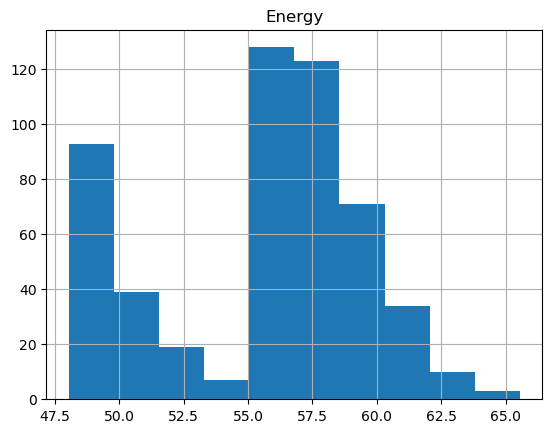

In [31]:
sub4.hist()

array([[<Axes: title={'center': 'Energy'}>]], dtype=object)

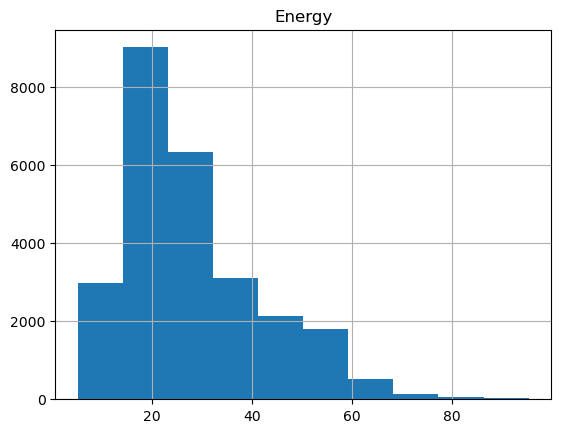

In [32]:
sub.hist()

In [33]:
sub.to_csv('sub.csv', index=False)
sub.describe()

,Energy
count,26139.000000
mean,28.188462
std,13.866515
min,5.082532
25%,18.378426
50%,24.309729
75%,35.459210
max,95.444810
